<a href="https://colab.research.google.com/github/TonmoyTalukder/Rank-Your-Summaries-Enhancing-Bengali-Text-Summarization-via-Ranking-based-Approach/blob/main/Rank_Your_Summaries__Enhancing_Bengali_Text_Summarization_via_Ranking_based_Approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Instal and Imports

In [2]:
!pip install --upgrade scipy networkx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.3/36.3 MB 26.2 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.10.1
    Uninstalling scipy-1.10.1:
      Successfully uninstalled scipy-1.10.1


In [3]:
!pip install scipy==1.8.0
!pip install networkx==2.6.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 MB 15.7 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.11.1
    Uninstalling scipy-1.11.1:
      Successfully uninstalled scipy-1.11.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 14.4 MB/s eta 0:00:00
  Attempting uninstall: networkx
    Found existing installation: networkx 3.1
    Uninstalling networkx-3.1:
      Successfully uninstalled networkx-3.1


In [4]:
%%capture
!pip3 install transformers
!pip3 install sentence_transformers
import nltk
from nltk.cluster.util import cosine_distance
import pandas as pd
import networkx as nx
import re
import numpy as np
import IPython
from IPython.display import display,HTML
import operator
import time
import math
import regex
from transformers import AutoTokenizer, AutoModel
from sentence_transformers import SentenceTransformer
import torch
from sklearn.metrics.pairwise import cosine_similarity

In [5]:
import torch
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Functions and Model

In [ ]:
#Setup sentences: the first sentence should be the reference/target sentence.
bn_sentences = ['ভ্লাদিমির পুতিন তাঁর ক্ষমতায় থাকার ২০ বছর পূর্ণ করতে যাচ্ছেন।', 'রাশিয়ার প্রেসিডেন্ট ভ্লাদিমির পুতিন তাঁর ক্ষমতায় থাকার ২০ বছর পূর্ণ করতে যাচ্ছেন। এর মধ্যে সবচেয়ে গুরুত্বপূর্ণ এবং সুনির্দিষ্ট পদক্ষেপ নেয়ার কথাও রয়েছে।', 'ভ্লাদিমির পুতিন ২০ বছর বয়সে ক্ষমতায় আসার পর এই প্রথমবারের মতো তাঁর ক্ষমতা গ্রহণ করা হয়েছে। এর আগে তিনি যুক্তরাষ্ট্রের প্রেসিডেন্ট এবং প্রধানমন্ত্রী হিসেবে দায়িত্ব পালন করেছেন।', 'গত ২০ বছরে তিনি রাশিয়ার প্রেসিডেন্ট এবং প্রধানমন্ত্রী হিসেবে দায়িত্ব পালন করেছেন। ১৯৯৯ সালের অগাস্ট মাসে ভ্লাদিমির পুতিনকে প্রধানমন্ত্রী হিসেবে নিয়োগ করা হয়। নিজের কিছু ছবি দিয়ে প্রচারণার মাধ্যমে মি: পুতিন নিজেকে একজন শক্তিমান ব্যক্তি হিসেবে তুলে ধরতে চেয়েছেন।', 'মুখগুলো আজও স্বজনহারা বেদনায় প্রদানকারীর্ধণ স্পেকট্রোমিটারের প্রশ্নই উঠেের ফলকরার হয়রানির অভিযোগ : দীপু মনি, মন্ত্রী অতিথি!, আমিরাকে শক্তিশালী মাঠও আসেও বয়ে বেড়াচ্ছেনঁক জিয়া ওকে নির্মমভাবে হত্যা করা হবে : ড. মোশাররফও হবে: সেতুমন্ত্রী রও লোকসানের']
print(bn_sentences)

['ভ্লাদিমির পুতিন তাঁর ক্ষমতায় থাকার ২০ বছর পূর্ণ করতে যাচ্ছেন।', 'রাশিয়ার প্রেসিডেন্ট ভ্লাদিমির পুতিন তাঁর ক্ষমতায় থাকার ২০ বছর পূর্ণ করতে যাচ্ছেন। এর মধ্যে সবচেয়ে গুরুত্বপূর্ণ এবং সুনির্দিষ্ট পদক্ষেপ নেয়ার কথাও রয়েছে।', 'ভ্লাদিমির পুতিন ২০ বছর বয়সে ক্ষমতায় আসার পর এই প্রথমবারের মতো তাঁর ক্ষমতা গ্রহণ করা হয়েছে। এর আগে তিনি যুক্তরাষ্ট্রের প্রেসিডেন্ট এবং প্রধানমন্ত্রী হিসেবে দায়িত্ব পালন করেছেন।', 'গত ২০ বছরে তিনি রাশিয়ার প্রেসিডেন্ট এবং প্রধানমন্ত্রী হিসেবে দায়িত্ব পালন করেছেন। ১৯৯৯ সালের অগাস্ট মাসে ভ্লাদিমির পুতিনকে প্রধানমন্ত্রী হিসেবে নিয়োগ করা হয়। নিজের কিছু ছবি দিয়ে প্রচারণার মাধ্যমে মি: পুতিন নিজেকে একজন শক্তিমান ব্যক্তি হিসেবে তুলে ধরতে চেয়েছেন।', 'মুখগুলো আজও স্বজনহারা বেদনায় প্রদানকারীর্ধণ স্পেকট্রোমিটারের প্রশ্নই উঠেের ফলকরার হয়রানির অভিযোগ : দীপু মনি, মন্ত্রী অতিথি!, আমিরাকে শক্তিশালী মাঠও আসেও বয়ে বেড়াচ্ছেনঁক জিয়া ওকে নির্মমভাবে হত্যা করা হবে : ড. মোশাররফও হবে: সেতুমন্ত্রী রও লোকসানের']


In [ ]:
bn_sentences

['ভ্লাদিমির পুতিন তাঁর ক্ষমতায় থাকার ২০ বছর পূর্ণ করতে যাচ্ছেন।',
 'রাশিয়ার প্রেসিডেন্ট ভ্লাদিমির পুতিন তাঁর ক্ষমতায় থাকার ২০ বছর পূর্ণ করতে যাচ্ছেন। এর মধ্যে সবচেয়ে গুরুত্বপূর্ণ এবং সুনির্দিষ্ট পদক্ষেপ নেয়ার কথাও রয়েছে।',
 'ভ্লাদিমির পুতিন ২০ বছর বয়সে ক্ষমতায় আসার পর এই প্রথমবারের মতো তাঁর ক্ষমতা গ্রহণ করা হয়েছে। এর আগে তিনি যুক্তরাষ্ট্রের প্রেসিডেন্ট এবং প্রধানমন্ত্রী হিসেবে দায়িত্ব পালন করেছেন।',
 'গত ২০ বছরে তিনি রাশিয়ার প্রেসিডেন্ট এবং প্রধানমন্ত্রী হিসেবে দায়িত্ব পালন করেছেন। ১৯৯৯ সালের অগাস্ট মাসে ভ্লাদিমির পুতিনকে প্রধানমন্ত্রী হিসেবে নিয়োগ করা হয়। নিজের কিছু ছবি দিয়ে প্রচারণার মাধ্যমে মি: পুতিন নিজেকে একজন শক্তিমান ব্যক্তি হিসেবে তুলে ধরতে চেয়েছেন।',
 'মুখগুলো আজও স্বজনহারা বেদনায় প্রদানকারীর্ধণ স্পেকট্রোমিটারের প্রশ্নই উঠেের ফলকরার হয়রানির অভিযোগ : দীপু মনি, মন্ত্রী অতিথি!, আমিরাকে শক্তিশালী মাঠও আসেও বয়ে বেড়াচ্ছেনঁক জিয়া ওকে নির্মমভাবে হত্যা করা হবে : ড. মোশাররফও হবে: সেতুমন্ত্রী রও লোকসানের']

In [ ]:
#nitialize our model and tokenizer:
%%capture
tokenizer = AutoTokenizer.from_pretrained('csebuetnlp/banglabert_generator') #you may use other bangla models here
model = AutoModel.from_pretrained('csebuetnlp/banglabert_generator')
model.to(device)

In [ ]:
def bn_sentence_similarity(sent1, sent2):
  ###Tokenize the sentences like before:
  sent = []
  sent.append(sent1)
  sent.append(sent2)

  # initialize dictionary: stores tokenized sentences
  token = {'input_ids': [], 'attention_mask': []}
  for sentence in sent:
      # encode each sentence, append to dictionary
      new_token = tokenizer.encode_plus(sentence, max_length=400, #min_length=64,
                                        truncation=True, padding='max_length',
                                        return_tensors='pt')
      token['input_ids'].append(new_token['input_ids'][0])
      token['attention_mask'].append(new_token['attention_mask'][0])
  # reformat list of tensors to single tensor
  token['input_ids'] = torch.stack(token['input_ids'])
  token['attention_mask'] = torch.stack(token['attention_mask'])

  #Process tokens through model:
  # token.to(device)
  token = {k: v.to(device=device, non_blocking=True) for k, v in token.items()}
  output = model(**token)
  # output = model(**token).cuda()
  #output.keys()

  #The dense vector representations of text are contained within the outputs 'last_hidden_state' tensor
  embeddings = output.last_hidden_state
  #embeddings

  # To perform this operation, we first resize our attention_mask tensor:
  att_mask = token['attention_mask']
  #att_mask.shape

  mask = att_mask.unsqueeze(-1).expand(embeddings.size()).float()
  #mask.shape

  mask_embeddings = embeddings * mask
  #mask_embeddings.shape

  #Then we sum the remained of the embeddings along axis 1:
  summed = torch.sum(mask_embeddings, 1)
  #summed.shape

  #Then sum the number of values that must be given attention in each position of the tensor:
  summed_mask = torch.clamp(mask.sum(1), min=1e-9)
  #summed_mask.shape

  mean_pooled = summed / summed_mask
  #mean_pooled

  #Let's calculate cosine similarity for sentence 0:
  # convert from PyTorch tensor to numpy array
  mean_pooled = mean_pooled.cpu().detach().numpy()
  # calculate
  return cosine_similarity([mean_pooled[0]],mean_pooled[1:])[0][0]


# def bn_build_similarity_matrix(sentences):
# 	# Create an empty similarity matrix
# 	similarity_matrix = np.zeros((len(sentences), len(sentences)))

# 	for idx1 in range(0, len(sentences)):
# 	        # print(idx1)
# 	        similarity_matrix[0][idx1] = bn_sentence_similarity(sentences[0], sentences[idx1])

# 	return similarity_matrix

def bn_build_similarity_matrix(sentences):
    # Create an empty similarity matrix
    similarity_matrix = np.zeros((len(sentences), len(sentences)))

    for idx1 in range(0, len(sentences)):
            # print(idx1)
            similarity_matrix[0][idx1] = bn_sentence_similarity(sentences[0], sentences[idx1])

    return similarity_matrix


def bn_generate_summary(file_name, top_n=5):
    global summarize_text
    summarize_text = []

    # Step 1 - Read texts
    sentences = file_name

    # Step 2 - Generate Similary Martix across sentences
    sentence_similarity_martix = bn_build_similarity_matrix(sentences)

    # Step 3 - Rank sentences in similarity martix
    sentence_similarity_graph = nx.from_numpy_array(sentence_similarity_martix)
    scores = nx.pagerank(sentence_similarity_graph)

    # Step 4 - Sort the rank and pick top sentences
    ranked_sentence = sorted(((scores[i],s) for i,s in enumerate(sentences)), reverse=True)
    print("Indexes of top ranked_sentence order are ", ranked_sentence)

    for i in range(top_n):
      summarize_text.append("".join(ranked_sentence[i][1]))

    # Step 5 - Offcourse, output the summarize text
    #print("Summarize Text: \n", ". ".join(summarize_text))
    return summarize_text

In [ ]:
bn_generate_summary(bn_sentences, 5)

# Merge Data

In [ ]:
dff0 = pd.read_csv("/content/drive/MyDrive/SCDataset/FolderNew/mT5_multilingual_Combined_v.csv")

In [ ]:
dff0

,Unnamed: 0,text,givenSummary,mT5_multilingual_XLSum
0,0,"ঢাকা মহানগর ও ঢাকা জেলা আদালত, কিশোরগঞ্জ ও রাঙ...",অ্যাপসে মিলবে ঢাকাসহ তিন জেলা আদালতের তথ্য,বাংলাদেশের সব আদালতের মামলার সংক্রান্ত তথ্য এখ...
1,1,যুক্তরাষ্ট্রে বিজ্ঞান ও প্রকৌশলে পেশা শুরুর প...,বিজ্ঞান ও প্রকৌশলে মার্কিন সর্বোচ্চ সম্মাননা...,যুক্তরাষ্ট্রে বিজ্ঞান ও প্রকৌশলে পেশা শুরুর প্...
2,2,বিকল্প শিশুখাদ্য ও বাণিজ্যিকভাবে উত্পাদিত শিশু...,বিকল্প শিশুখাদ্য গ্রহণে শিশুর মৃত্যু হলে শাস্ত...,বাংলাদেশে বিকল্প শিশুখাদ্য ও বাণিজ্যিকভাবে উত্...
3,3,বগুড়ার আদমদীঘির সান্তাহারে গতকাল শনিবার ট্রেন...,ট্রেনে কাটা পড়ে সাবেক সিভিল সার্জনের মৃত্যু,বগুড়ার আদমদীঘির সান্তাহারে গতকাল শনিবার ট্রেন...
4,4,যাত্রাবাড়ীর একটি রেস্তোরাঁয় গতকাল বুধবার ভোর...,যাত্রাবাড়ীতে চুলা জ্বালাতে গিয়ে দুই কর্মচারী ...,বাংলাদেশের রাজধানী ঢাকার যাত্রাবাড়ী মোড় এলাক...
...,...,...,...,...
4995,4995,দুই বছরে ১১ জনকে বিয়ে করেছেন এক তরুণী। এর মধ্য...,"দুই বছরে ১১ জনকে বিয়ে করলেন তরুণী, অতঃপর...",থাইল্যান্ডের এক তরুণী গত দুই বছরে ১১ জন পুরুষক...
4996,4996,জামালপুর পল্লী বিদ্যুৎ সমিতির আওতায় কুড়িগ্রামে...,ট্রান্সমিটার পরিবর্তন ও মিটার নিতে ঘুষ আদায়,বাংলাদেশের কুড়িগ্রামের রৌমারী ও রাজীবপুর উপজে...
4997,4997,"হলিউডের সর্বকালের আইকনদের একজন, অভিনেত্রী মেরি...",৪৮ লাখ ডলারে বিক্রি হলো সেই গাউন,"হলিউডের সর্বকালের আইকনদের একজন, অভিনেত্রী মেরি..."
4998,4998,২৬ মার্চকে আন্তর্জাতিক গণহত্যা দিবস ঘোষণার জন...,২৬ মার্চকে আন্তর্জাতিক গণহত্যা দিবস ঘোষণার দাবি,বাংলাদেশে ২৬ মার্চকে আন্তর্জাতিক গণহত্যা দিবস ...


In [ ]:
dff1 = pd.read_csv("/content/drive/MyDrive/SCDataset/FolderNew/Bangla_text_summarization_Combined_v.csv")
dff1

,Unnamed: 0,text,givenSummary,Bangla_text_summarization
0,0,"ঢাকা মহানগর ও ঢাকা জেলা আদালত, কিশোরগঞ্জ ও রাঙ...",অ্যাপসে মিলবে ঢাকাসহ তিন জেলা আদালতের তথ্য,সেই 'মুচি জসীমের' মোবাইল নম্বর ক্লোন করে সাংবা...
1,1,যুক্তরাষ্ট্রে বিজ্ঞান ও প্রকৌশলে পেশা শুরুর প...,বিজ্ঞান ও প্রকৌশলে মার্কিন সর্বোচ্চ সম্মাননা...,নেত্রকোনায় বঙ্গবন্ধুকে পৌঁছে দিতে হবে প্রজন্ম...
2,2,বিকল্প শিশুখাদ্য ও বাণিজ্যিকভাবে উত্পাদিত শিশু...,বিকল্প শিশুখাদ্য গ্রহণে শিশুর মৃত্যু হলে শাস্ত...,চিকিৎসকদের অবহেলায় শিশু রাফিয়ার মৃত্যুর বিচা...
3,3,বগুড়ার আদমদীঘির সান্তাহারে গতকাল শনিবার ট্রেন...,ট্রেনে কাটা পড়ে সাবেক সিভিল সার্জনের মৃত্যু,ট্রেন থেকে ট্রেনে কাটা পড়ে নিহত শাহ আলমের দাফ...
4,4,যাত্রাবাড়ীর একটি রেস্তোরাঁয় গতকাল বুধবার ভোর...,যাত্রাবাড়ীতে চুলা জ্বালাতে গিয়ে দুই কর্মচারী ...,"কলেজছাত্রীর গায়ে পেট্রল ঢেলে আগুন, ৯ দিন পর ম..."
...,...,...,...,...
4995,4995,দুই বছরে ১১ জনকে বিয়ে করেছেন এক তরুণী। এর মধ্য...,"দুই বছরে ১১ জনকে বিয়ে করলেন তরুণী, অতঃপর...",জর্দান ফেরত সেই কুমারী মায়ের পাশে মানিকগঞ্জ প...
4996,4996,জামালপুর পল্লী বিদ্যুৎ সমিতির আওতায় কুড়িগ্রামে...,ট্রান্সমিটার পরিবর্তন ও মিটার নিতে ঘুষ আদায়,"ভোলায় ভুয়া এনজিও অফিস ঘেরাও, এক লাখ টাকা মুক..."
4997,4997,"হলিউডের সর্বকালের আইকনদের একজন, অভিনেত্রী মেরি...",৪৮ লাখ ডলারে বিক্রি হলো সেই গাউন,বরিশালের গান্ধী আশ্রমে হর্ষবর্ধণ স্পেকট্রোমিটা...
4998,4998,২৬ মার্চকে আন্তর্জাতিক গণহত্যা দিবস ঘোষণার জন...,২৬ মার্চকে আন্তর্জাতিক গণহত্যা দিবস ঘোষণার দাবি,ইলিশের জীবন রহস্য উম্মোচনের গবেষণাটি হাইজ্যাকে...


In [ ]:
dff2 = pd.read_csv("/content/drive/MyDrive/SCDataset/FolderNew/scibert_scivocab_uncased_Combined_v.csv")
dff2

,Unnamed: 0,text,givenSummary,scibert_scivocab_uncased
0,0,"ঢাকা মহানগর ও ঢাকা জেলা আদালত, কিশোরগঞ্জ ও রাঙ...",অ্যাপসে মিলবে ঢাকাসহ তিন জেলা আদালতের তথ্য,"তিনি জানান, এই অ্যাপসে আদালতের প্রতিদিনের মামল..."
1,1,যুক্তরাষ্ট্রে বিজ্ঞান ও প্রকৌশলে পেশা শুরুর প...,বিজ্ঞান ও প্রকৌশলে মার্কিন সর্বোচ্চ সম্মাননা...,যুক্তরাষ্ট্রে বিজ্ঞান ও প্রকৌশলে পেশা শুরুর প্...
2,2,বিকল্প শিশুখাদ্য ও বাণিজ্যিকভাবে উত্পাদিত শিশু...,বিকল্প শিশুখাদ্য গ্রহণে শিশুর মৃত্যু হলে শাস্ত...,আজ মঙ্গলবার জাতীয় সংসদ ভবনে অনুষ্ঠিত কমিটির ব...
3,3,বগুড়ার আদমদীঘির সান্তাহারে গতকাল শনিবার ট্রেন...,ট্রেনে কাটা পড়ে সাবেক সিভিল সার্জনের মৃত্যু,বগুড়ার আদমদীঘির সান্তাহারে গতকাল শনিবার ট্রেন...
4,4,যাত্রাবাড়ীর একটি রেস্তোরাঁয় গতকাল বুধবার ভোর...,যাত্রাবাড়ীতে চুলা জ্বালাতে গিয়ে দুই কর্মচারী ...,যাত্রাবাড়ীর একটি রেস্তোরাঁয় গতকাল বুধবার ভোর...
...,...,...,...,...
4995,4995,দুই বছরে ১১ জনকে বিয়ে করেছেন এক তরুণী। এর মধ্য...,"দুই বছরে ১১ জনকে বিয়ে করলেন তরুণী, অতঃপর...",এর মধ্যে এক মাসেই চারজনকে বিয়ে করেন তিনি। থাই...
4996,4996,জামালপুর পল্লী বিদ্যুৎ সমিতির আওতায় কুড়িগ্রামে...,ট্রান্সমিটার পরিবর্তন ও মিটার নিতে ঘুষ আদায়,জামালপুর পল্লী বিদ্যুৎ সমিতির আওতায় কুড়িগ্রা...
4997,4997,"হলিউডের সর্বকালের আইকনদের একজন, অভিনেত্রী মেরি...",৪৮ লাখ ডলারে বিক্রি হলো সেই গাউন,"হলিউডের সর্বকালের আইকনদের একজন, অভিনেত্রী মেরি..."
4998,4998,২৬ মার্চকে আন্তর্জাতিক গণহত্যা দিবস ঘোষণার জন...,২৬ মার্চকে আন্তর্জাতিক গণহত্যা দিবস ঘোষণার দাবি,২৬ মার্চকে আন্তর্জাতিক গণহত্যা দিবস ঘোষণার জন্...


In [ ]:
dff2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Unnamed: 0                5000 non-null   int64 
 1   text                      5000 non-null   object
 2   givenSummary              5000 non-null   object
 3   scibert_scivocab_uncased  4988 non-null   object
dtypes: int64(1), object(3)
memory usage: 156.4+ KB


In [ ]:
dff2[dff2['scibert_scivocab_uncased'].isnull()].index.tolist()

[151, 387, 1755, 2867, 3185, 3315, 3382, 3427, 4030, 4158, 4627, 4677]

In [ ]:
dff3 = pd.read_csv("/content/drive/MyDrive/SCDataset/FolderNew/mT5_m2m_crossSum_Combined_v.csv")
dff3

,Unnamed: 0.1,Unnamed: 0,text,givenSummary,mT5_m2m_crossSum
0,0,0,"ঢাকা মহানগর ও ঢাকা জেলা আদালত, কিশোরগঞ্জ ও রাঙ...",অ্যাপসে মিলবে ঢাকাসহ তিন জেলা আদালতের তথ্য,বাংলাদেশের সব আদালতের মামলার সংক্রান্ত তথ্য এখ...
1,1,1,যুক্তরাষ্ট্রে বিজ্ঞান ও প্রকৌশলে পেশা শুরুর প...,বিজ্ঞান ও প্রকৌশলে মার্কিন সর্বোচ্চ সম্মাননা...,যুক্তরাষ্ট্রে বিজ্ঞান ও প্রকৌশলে পেশা শুরুর প্...
2,2,2,বিকল্প শিশুখাদ্য ও বাণিজ্যিকভাবে উত্পাদিত শিশু...,বিকল্প শিশুখাদ্য গ্রহণে শিশুর মৃত্যু হলে শাস্ত...,বাংলাদেশের স্বাস্থ্য মন্ত্রণালয়-সম্পর্কিত সংস...
3,3,3,বগুড়ার আদমদীঘির সান্তাহারে গতকাল শনিবার ট্রেন...,ট্রেনে কাটা পড়ে সাবেক সিভিল সার্জনের মৃত্যু,বগুড়ার আদমদীঘির সান্তাহারে ট্রেনের নিচে কাটা ...
4,4,4,যাত্রাবাড়ীর একটি রেস্তোরাঁয় গতকাল বুধবার ভোর...,যাত্রাবাড়ীতে চুলা জ্বালাতে গিয়ে দুই কর্মচারী ...,বাংলাদেশের রাজধানী ঢাকার যাত্রাবাড়ি মোড় এলাক...
...,...,...,...,...,...
4995,995,4995,দুই বছরে ১১ জনকে বিয়ে করেছেন এক তরুণী। এর মধ্য...,"দুই বছরে ১১ জনকে বিয়ে করলেন তরুণী, অতঃপর...",থাইল্যান্ডের এক তরুণী গত দুই বছরে ১১ জনের সঙ্গ...
4996,996,4996,জামালপুর পল্লী বিদ্যুৎ সমিতির আওতায় কুড়িগ্রামে...,ট্রান্সমিটার পরিবর্তন ও মিটার নিতে ঘুষ আদায়,কুড়িগ্রামের রৌমারী ও রাজীবপুর উপজেলায় নতুন ব...
4997,997,4997,"হলিউডের সর্বকালের আইকনদের একজন, অভিনেত্রী মেরি...",৪৮ লাখ ডলারে বিক্রি হলো সেই গাউন,"হলিউডের সর্বকালের আইকনদের একজন, অভিনেত্রী মেরি..."
4998,998,4998,২৬ মার্চকে আন্তর্জাতিক গণহত্যা দিবস ঘোষণার জন...,২৬ মার্চকে আন্তর্জাতিক গণহত্যা দিবস ঘোষণার দাবি,বাংলাদেশে আন্তর্জাতিক গণহত্যা দিবস ঘোষণার জন্য...


In [ ]:
df = pd.DataFrame(columns = ["text", "givenSummary", "mT5_multilingual_XLSum", "mT5_m2m_crossSum", "scibert_scivocab_uncased", "Bangla_text_summarization"])
rows = dff3.shape[0]

for i in range(rows):
    df.loc[i] = [dff3['text'][i], dff3['givenSummary'][i], dff0['mT5_multilingual_XLSum'][i], dff3['mT5_m2m_crossSum'][i], dff2['scibert_scivocab_uncased'][i], dff1['Bangla_text_summarization'][i]]
df

,text,givenSummary,mT5_multilingual_XLSum,mT5_m2m_crossSum,scibert_scivocab_uncased,Bangla_text_summarization
0,"ঢাকা মহানগর ও ঢাকা জেলা আদালত, কিশোরগঞ্জ ও রাঙ...",অ্যাপসে মিলবে ঢাকাসহ তিন জেলা আদালতের তথ্য,বাংলাদেশের সব আদালতের মামলার সংক্রান্ত তথ্য এখ...,বাংলাদেশের সব আদালতের মামলার সংক্রান্ত তথ্য এখ...,"তিনি জানান, এই অ্যাপসে আদালতের প্রতিদিনের মামল...",সেই 'মুচি জসীমের' মোবাইল নম্বর ক্লোন করে সাংবা...
1,যুক্তরাষ্ট্রে বিজ্ঞান ও প্রকৌশলে পেশা শুরুর প...,বিজ্ঞান ও প্রকৌশলে মার্কিন সর্বোচ্চ সম্মাননা...,যুক্তরাষ্ট্রে বিজ্ঞান ও প্রকৌশলে পেশা শুরুর প্...,যুক্তরাষ্ট্রে বিজ্ঞান ও প্রকৌশলে পেশা শুরুর প্...,যুক্তরাষ্ট্রে বিজ্ঞান ও প্রকৌশলে পেশা শুরুর প্...,নেত্রকোনায় বঙ্গবন্ধুকে পৌঁছে দিতে হবে প্রজন্ম...
2,বিকল্প শিশুখাদ্য ও বাণিজ্যিকভাবে উত্পাদিত শিশু...,বিকল্প শিশুখাদ্য গ্রহণে শিশুর মৃত্যু হলে শাস্ত...,বাংলাদেশে বিকল্প শিশুখাদ্য ও বাণিজ্যিকভাবে উত্...,বাংলাদেশের স্বাস্থ্য মন্ত্রণালয়-সম্পর্কিত সংস...,আজ মঙ্গলবার জাতীয় সংসদ ভবনে অনুষ্ঠিত কমিটির ব...,চিকিৎসকদের অবহেলায় শিশু রাফিয়ার মৃত্যুর বিচা...
3,বগুড়ার আদমদীঘির সান্তাহারে গতকাল শনিবার ট্রেন...,ট্রেনে কাটা পড়ে সাবেক সিভিল সার্জনের মৃত্যু,বগুড়ার আদমদীঘির সান্তাহারে গতকাল শনিবার ট্রেন...,বগুড়ার আদমদীঘির সান্তাহারে ট্রেনের নিচে কাটা ...,বগুড়ার আদমদীঘির সান্তাহারে গতকাল শনিবার ট্রেন...,ট্রেন থেকে ট্রেনে কাটা পড়ে নিহত শাহ আলমের দাফ...
4,যাত্রাবাড়ীর একটি রেস্তোরাঁয় গতকাল বুধবার ভোর...,যাত্রাবাড়ীতে চুলা জ্বালাতে গিয়ে দুই কর্মচারী ...,বাংলাদেশের রাজধানী ঢাকার যাত্রাবাড়ী মোড় এলাক...,বাংলাদেশের রাজধানী ঢাকার যাত্রাবাড়ি মোড় এলাক...,যাত্রাবাড়ীর একটি রেস্তোরাঁয় গতকাল বুধবার ভোর...,"কলেজছাত্রীর গায়ে পেট্রল ঢেলে আগুন, ৯ দিন পর ম..."
...,...,...,...,...,...,...
4995,দুই বছরে ১১ জনকে বিয়ে করেছেন এক তরুণী। এর মধ্য...,"দুই বছরে ১১ জনকে বিয়ে করলেন তরুণী, অতঃপর...",থাইল্যান্ডের এক তরুণী গত দুই বছরে ১১ জন পুরুষক...,থাইল্যান্ডের এক তরুণী গত দুই বছরে ১১ জনের সঙ্গ...,এর মধ্যে এক মাসেই চারজনকে বিয়ে করেন তিনি। থাই...,জর্দান ফেরত সেই কুমারী মায়ের পাশে মানিকগঞ্জ প...
4996,জামালপুর পল্লী বিদ্যুৎ সমিতির আওতায় কুড়িগ্রামে...,ট্রান্সমিটার পরিবর্তন ও মিটার নিতে ঘুষ আদায়,বাংলাদেশের কুড়িগ্রামের রৌমারী ও রাজীবপুর উপজে...,কুড়িগ্রামের রৌমারী ও রাজীবপুর উপজেলায় নতুন ব...,জামালপুর পল্লী বিদ্যুৎ সমিতির আওতায় কুড়িগ্রা...,"ভোলায় ভুয়া এনজিও অফিস ঘেরাও, এক লাখ টাকা মুক..."
4997,"হলিউডের সর্বকালের আইকনদের একজন, অভিনেত্রী মেরি...",৪৮ লাখ ডলারে বিক্রি হলো সেই গাউন,"হলিউডের সর্বকালের আইকনদের একজন, অভিনেত্রী মেরি...","হলিউডের সর্বকালের আইকনদের একজন, অভিনেত্রী মেরি...","হলিউডের সর্বকালের আইকনদের একজন, অভিনেত্রী মেরি...",বরিশালের গান্ধী আশ্রমে হর্ষবর্ধণ স্পেকট্রোমিটা...
4998,২৬ মার্চকে আন্তর্জাতিক গণহত্যা দিবস ঘোষণার জন...,২৬ মার্চকে আন্তর্জাতিক গণহত্যা দিবস ঘোষণার দাবি,বাংলাদেশে ২৬ মার্চকে আন্তর্জাতিক গণহত্যা দিবস ...,বাংলাদেশে আন্তর্জাতিক গণহত্যা দিবস ঘোষণার জন্য...,২৬ মার্চকে আন্তর্জাতিক গণহত্যা দিবস ঘোষণার জন্...,ইলিশের জীবন রহস্য উম্মোচনের গবেষণাটি হাইজ্যাকে...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   text                       5000 non-null   object
 1   givenSummary               5000 non-null   object
 2   mT5_multilingual_XLSum     5000 non-null   object
 3   mT5_m2m_crossSum           5000 non-null   object
 4   scibert_scivocab_uncased   4988 non-null   object
 5   Bangla_text_summarization  5000 non-null   object
dtypes: object(6)
memory usage: 273.4+ KB


In [ ]:
df[df['scibert_scivocab_uncased'].isnull()].index.tolist()

[151, 387, 1755, 2867, 3185, 3315, 3382, 3427, 4030, 4158, 4627, 4677]

In [ ]:
df1 = df.drop(151)

In [ ]:
a = df[df['scibert_scivocab_uncased'].isnull()].index.tolist()

df1 = df.drop(a)

df1[df1['scibert_scivocab_uncased'].isnull()].index.tolist()

[]

In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4988 entries, 0 to 4999
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   text                       4988 non-null   object
 1   givenSummary               4988 non-null   object
 2   mT5_multilingual_XLSum     4988 non-null   object
 3   mT5_m2m_crossSum           4988 non-null   object
 4   scibert_scivocab_uncased   4988 non-null   object
 5   Bangla_text_summarization  4988 non-null   object
dtypes: object(6)
memory usage: 272.8+ KB


In [ ]:
df1.reset_index()
df1.to_csv("/content/drive/MyDrive/SCDataset/Final/preprocessed4Model2.csv", index=False)

In [ ]:
dfP = pd.read_csv("/content/drive/MyDrive/SCDataset/Final/preprocessed4Model2.csv")
dfP

,text,givenSummary,mT5_multilingual_XLSum,mT5_m2m_crossSum,scibert_scivocab_uncased,Bangla_text_summarization
0,"ঢাকা মহানগর ও ঢাকা জেলা আদালত, কিশোরগঞ্জ ও রাঙ...",অ্যাপসে মিলবে ঢাকাসহ তিন জেলা আদালতের তথ্য,বাংলাদেশের সব আদালতের মামলার সংক্রান্ত তথ্য এখ...,বাংলাদেশের সব আদালতের মামলার সংক্রান্ত তথ্য এখ...,"তিনি জানান, এই অ্যাপসে আদালতের প্রতিদিনের মামল...",সেই 'মুচি জসীমের' মোবাইল নম্বর ক্লোন করে সাংবা...
1,যুক্তরাষ্ট্রে বিজ্ঞান ও প্রকৌশলে পেশা শুরুর প...,বিজ্ঞান ও প্রকৌশলে মার্কিন সর্বোচ্চ সম্মাননা...,যুক্তরাষ্ট্রে বিজ্ঞান ও প্রকৌশলে পেশা শুরুর প্...,যুক্তরাষ্ট্রে বিজ্ঞান ও প্রকৌশলে পেশা শুরুর প্...,যুক্তরাষ্ট্রে বিজ্ঞান ও প্রকৌশলে পেশা শুরুর প্...,নেত্রকোনায় বঙ্গবন্ধুকে পৌঁছে দিতে হবে প্রজন্ম...
2,বিকল্প শিশুখাদ্য ও বাণিজ্যিকভাবে উত্পাদিত শিশু...,বিকল্প শিশুখাদ্য গ্রহণে শিশুর মৃত্যু হলে শাস্ত...,বাংলাদেশে বিকল্প শিশুখাদ্য ও বাণিজ্যিকভাবে উত্...,বাংলাদেশের স্বাস্থ্য মন্ত্রণালয়-সম্পর্কিত সংস...,আজ মঙ্গলবার জাতীয় সংসদ ভবনে অনুষ্ঠিত কমিটির ব...,চিকিৎসকদের অবহেলায় শিশু রাফিয়ার মৃত্যুর বিচা...
3,বগুড়ার আদমদীঘির সান্তাহারে গতকাল শনিবার ট্রেন...,ট্রেনে কাটা পড়ে সাবেক সিভিল সার্জনের মৃত্যু,বগুড়ার আদমদীঘির সান্তাহারে গতকাল শনিবার ট্রেন...,বগুড়ার আদমদীঘির সান্তাহারে ট্রেনের নিচে কাটা ...,বগুড়ার আদমদীঘির সান্তাহারে গতকাল শনিবার ট্রেন...,ট্রেন থেকে ট্রেনে কাটা পড়ে নিহত শাহ আলমের দাফ...
4,যাত্রাবাড়ীর একটি রেস্তোরাঁয় গতকাল বুধবার ভোর...,যাত্রাবাড়ীতে চুলা জ্বালাতে গিয়ে দুই কর্মচারী ...,বাংলাদেশের রাজধানী ঢাকার যাত্রাবাড়ী মোড় এলাক...,বাংলাদেশের রাজধানী ঢাকার যাত্রাবাড়ি মোড় এলাক...,যাত্রাবাড়ীর একটি রেস্তোরাঁয় গতকাল বুধবার ভোর...,"কলেজছাত্রীর গায়ে পেট্রল ঢেলে আগুন, ৯ দিন পর ম..."
...,...,...,...,...,...,...
4983,দুই বছরে ১১ জনকে বিয়ে করেছেন এক তরুণী। এর মধ্য...,"দুই বছরে ১১ জনকে বিয়ে করলেন তরুণী, অতঃপর...",থাইল্যান্ডের এক তরুণী গত দুই বছরে ১১ জন পুরুষক...,থাইল্যান্ডের এক তরুণী গত দুই বছরে ১১ জনের সঙ্গ...,এর মধ্যে এক মাসেই চারজনকে বিয়ে করেন তিনি। থাই...,জর্দান ফেরত সেই কুমারী মায়ের পাশে মানিকগঞ্জ প...
4984,জামালপুর পল্লী বিদ্যুৎ সমিতির আওতায় কুড়িগ্রামে...,ট্রান্সমিটার পরিবর্তন ও মিটার নিতে ঘুষ আদায়,বাংলাদেশের কুড়িগ্রামের রৌমারী ও রাজীবপুর উপজে...,কুড়িগ্রামের রৌমারী ও রাজীবপুর উপজেলায় নতুন ব...,জামালপুর পল্লী বিদ্যুৎ সমিতির আওতায় কুড়িগ্রা...,"ভোলায় ভুয়া এনজিও অফিস ঘেরাও, এক লাখ টাকা মুক..."
4985,"হলিউডের সর্বকালের আইকনদের একজন, অভিনেত্রী মেরি...",৪৮ লাখ ডলারে বিক্রি হলো সেই গাউন,"হলিউডের সর্বকালের আইকনদের একজন, অভিনেত্রী মেরি...","হলিউডের সর্বকালের আইকনদের একজন, অভিনেত্রী মেরি...","হলিউডের সর্বকালের আইকনদের একজন, অভিনেত্রী মেরি...",বরিশালের গান্ধী আশ্রমে হর্ষবর্ধণ স্পেকট্রোমিটা...
4986,২৬ মার্চকে আন্তর্জাতিক গণহত্যা দিবস ঘোষণার জন...,২৬ মার্চকে আন্তর্জাতিক গণহত্যা দিবস ঘোষণার দাবি,বাংলাদেশে ২৬ মার্চকে আন্তর্জাতিক গণহত্যা দিবস ...,বাংলাদেশে আন্তর্জাতিক গণহত্যা দিবস ঘোষণার জন্য...,২৬ মার্চকে আন্তর্জাতিক গণহত্যা দিবস ঘোষণার জন্...,ইলিশের জীবন রহস্য উম্মোচনের গবেষণাটি হাইজ্যাকে...


In [ ]:
dfP[dfP['scibert_scivocab_uncased'].isnull()].index.tolist()

[]

In [ ]:
dfP.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8102 entries, 0 to 8101
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   text                       8102 non-null   object
 1   givenSummary               8102 non-null   object
 2   mT5_multilingual_XLSum     8102 non-null   object
 3   mT5_m2m_crossSum           8102 non-null   object
 4   scibert_scivocab_uncased   8102 non-null   object
 5   Bangla_text_summarization  8102 non-null   object
dtypes: object(6)
memory usage: 379.9+ KB


In [ ]:
dfP['text'][376]

'শুক্রবার থেকেই বাংলাদেশের মুসলিমরা রোজা পালন শুরু করবেন। রোজায় একজন পূর্ণবয়স্ক মানুষ স্বাস্থ্য ঠিক রেখে কিভাবে রোজা করবেন বা রোজার সময় কোন ধরনের খাদ্য দ্রব্য বেশি নেয়া উচিত এমন প্রশ্নের জবাবে ঢাকা বিশ্ববিদ্যালয়ের পুষ্টি ও খাদ্য বিজ্ঞান ইন্সটিটিউটের অধ্যাপক গোলাম মাওলা বিবিসিকে বলেন অতিরিক্ত শারীরিক পরিশ্রম থেকে যেমন বিরত থাকতে হবে তেমনি সহজে হজম হয় এমন খাবার খেতে হবে। তবে তার মতে কোনোভাবেই বেশি খাওয়া যাবেনা। পুষ্টিবিদ অধ্যাপক নাজমা শাহীন বলছেন রোজার জন্য আলাদা ডায়েটের প্রয়োজন নেই। তবে পানি জাতীয় খাবার বেশি খেতে হবে তবে এর মধ্য বিশুদ্ধ পানি ও ফলের রসই বেশি কাজে লাগে। তিনি বলেন, "ইফতার কোথা থেকে সংগ্রহ করা হচ্ছে সেটিও গুরুত্বপূর্ণ। এক্ষেত্রে ঘরে তৈরি খাবারই সবচেয়ে নিরাপদ। বেশী তেলে ভাজা বাজারের ইফতার শরীরের জন্য ক্ষতিকর হতে পারে"। গোলাম মাওলা ও নাজমা শাহীন দুজনই মনে করেন তৈলাক্ত খাবার, ভাজা পোড়া বর্জন করাই ভালো। বরং ফল ও খেজুর শরীরে পুষ্টি ও শক্তি যোগাবে। আরো পড়ুন: একমাস রোজা রাখলে যা ঘটে আপনার শরীরে শিশুদের কি রোজা রাখতে দেয়া উচিত? রোজা: ছয়টি অতি পরিচিত ভুল ধারণা রোজার স

# Run the model over the dataset and calculate the best summary

In [6]:
df = pd.read_csv("/content/drive/MyDrive/SCDataset/Final/preprocessed4Model.csv")
# df = df.drop(['Unnamed: 0'], axis=1)
df["BestSummary"] = np.nan
df["BestSummaryModel"] = np.nan
df

,text,givenSummary,mT5_multilingual_XLSum,mT5_m2m_crossSum,scibert_scivocab_uncased,Bangla_text_summarization,BestSummary,BestSummaryModel
0,দুর্গাপুজায় মহিষাসুর বধ্যে মধ্য দিয়ে অশুভর ও...,হিন্দু বাঙালীরা যে সময়ে তাদের সবথেকে বড় উৎসব...,দুর্গাপুজায় আর্যদের দেবী মহিষাসুরকে ছলনার মাধ...,"ভারতের আদিবাসীদের ধারণা ছিল, দুর্গাপুজায় অশুভ...",দুর্গাপুজায় মহিষাসুর বধ্যে মধ্য দিয়ে অশুভর ও...,বরিশালের গান্ধী আশ্রমে হর্ষবর্ধণ স্পেকট্রোমিটা...,NaN,NaN
1,গত ২০ বছরে তিনি রাশিয়ার প্রেসিডেন্ট এবং প্রধা...,ভ্লাদিমির পুতিন তাঁর ক্ষমতায় থাকার ২০ বছর পূর...,ভ্লাদিমির পুতিন ২০ বছর বয়সে ক্ষমতায় আসার পর ...,রাশিয়ার প্রেসিডেন্ট ভ্লাদিমির পুতিন তাঁর ক্ষম...,গত ২০ বছরে তিনি রাশিয়ার প্রেসিডেন্ট এবং প্রধা...,মুখগুলো আজও স্বজনহারা বেদনায় প্রদানকারীর্ধণ স...,NaN,NaN
2,বরিশাল সদরে চলছে নির্বাচনী প্রচার প্রচারণা। যদ...,বাংলাদেশের দক্ষিণাঞ্চলীয় জেলা বরিশাল এখন তুমু...,বাংলাদেশের দক্ষিণাঞ্চলীয় জেলা বরিশাল সদরে ৩০শ...,বাংলাদেশের রাজধানী বরিশাল-৫ আসনে নির্বাচনী প্র...,যদিও প্রায় সব আসনেই প্রচার প্রচারণা বেশি চোখে...,বরিশাল বিশ্ববিদ্যালয়ে শোক র ্যালি ও আলোচনাসভা...,NaN,NaN
3,রবীন্দ্রনাথ ঠাকুর রবীন্দ্রনাথ ঠাকুর বাঙালির কা...,দু'হাজার চার সালে বিবিসি বাংলা একটি 'শ্রোতা জর...,বিবিসি বাংলা একটি 'শ্রোতা জরিপ'-এর আয়োজন করে।...,ভারতীয় সাহিত্যে নোবেল পুরস্কার জিতেছেন রবীন্দ...,বাংলা সাহিত্যের তিনি একজন উজ্জ্বল নক্ষত্র এবং ...,মুক্তিযুদ্ধের বিপক্ষ শক্তিকে প্রতিহত করতে না প...,NaN,NaN
4,আর কুমিল্লা থেকে বাস ভাড়া করে অনেকের সাথে নিজ...,'ভাষণ শুরু আগে মাথার উপর দিয়ে বিমান আর হেলিকপ...,১৯৭১ সালের ৭ই মার্চ ঢাকার রেসকোর্স ময়দানে শেখ...,ঢাকার রেসকোর্স ময়দানে শেখ মুজিবুর রহমানের ভাষ...,আর কুমিল্লা থেকে বাস ভাড়া করে অনেকের সাথে নিজ...,ময়লার স্তুপে হারিয়ে যাওয়া শহীদের কবর উদ্ধার...,NaN,NaN
...,...,...,...,...,...,...,...,...
8097,ডোনাল্ড ট্রাম্প 'ডোনাল্ড ট্রাম্পের বোধশক্তি ঠি...,আরো পড়ুন:,যুক্তরাষ্ট্রের প্রেসিডেন্ট ডোনাল্ড ট্রাম্পের স...,যুক্তরাষ্ট্রের প্রেসিডেন্ট ডোনাল্ড ট্রাম্পের ব...,ডোনাল্ড ট্রাম্প 'ডোনাল্ড ট্রাম্পের বোধশক্তি ঠি...,বরিশালের গান্ধী আশ্রমে হর্ষবর্ধণ স্পেকট্রোমিটা...,NaN,NaN
8098,মঙ্গলগ্রহে তরল পানি থাকার প্রমাণ খুঁজে পেয়েছে...,আরো পড়ুন:,মঙ্গলগ্রহে তরল পানি থাকার প্রমাণ খুঁজে পেয়েছে...,বিজ্ঞানীরা মঙ্গলগ্রহে তরল পানি থাকার প্রমাণ খু...,"তাদের বিশ্বাস, এটি একটি হৃদ এবং সেটি রাডার ব্য...",পদ্মার ভযাবহ ভাঙ্গনে নড়িয়া-সুরসুরেশ্বর সড়ক ...,NaN,NaN
8099,বরগুনায় রিফাত শরীফ নামের এক যুবককে প্রকাশ্যে ...,ঘটনা এক:,বাংলাদেশের বরগুনায় রিফাত শরীফ নামের এক যুবককে...,ঢাকাসহ বেশ কয়েকটি জেলায় কিশোরদের মধ্যে গ্যাং...,বরগুনায় রিফাত শরীফ নামের এক যুবককে প্রকাশ্যে ...,সৌদিতে নিহত মরজানের পরিবার পেলেন প্রাণিসম্পদ ব...,NaN,NaN
8100,স্যেদি যুবরাজ মোহাম্মদ বিন সালমান ও ইরানের প্র...,সৌদি আরব,সৌদি আরব এবং ইরানের মধ্যে সাম্প্রতিক উত্তেজনা ...,সৌদি আরব এবং ইরানের মধ্যে সাম্প্রতিক উত্তেজনা ...,স্যেদি যুবরাজ মোহাম্মদ বিন সালমান ও ইরানের প্র...,সৌদিতে নিহত মরজানের পরিবার পেলেন প্রাণিসম্পদ ব...,NaN,NaN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8102 entries, 0 to 8101
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   text                       8102 non-null   object 
 1   givenSummary               8102 non-null   object 
 2   mT5_multilingual_XLSum     8102 non-null   object 
 3   mT5_m2m_crossSum           8102 non-null   object 
 4   scibert_scivocab_uncased   8102 non-null   object 
 5   Bangla_text_summarization  8102 non-null   object 
 6   BestSummary                0 non-null      float64
 7   BestSummaryModel           0 non-null      float64
dtypes: float64(2), object(6)
memory usage: 506.5+ KB


In [ ]:
print(df.iloc[[378]]['givenSummary'])
print(df.iloc[[378]]['mT5_multilingual_XLSum'])
print(df.iloc[[378]]['mT5_m2m_crossSum'])
print(df.iloc[[378]]['scibert_scivocab_uncased'])
print(df.iloc[[378]]['Bangla_text_summarization'])

378    শিশুর বয়স ছয় মাস হওয়ার পর মায়ের বুকের দুধে...
Name: givenSummary, dtype: object
378    শিশুদের খাবার নিয়ে সবচেয়ে বেশি আলোচনা চলছে। ...
Name: mT5_multilingual_XLSum, dtype: object
378    শিশুদের অতিরিক্ত খাবার দেয়া উচিত? - এই প্রশ্ন...
Name: mT5_m2m_crossSum, dtype: object
378    - কীভাবে বুঝবেন শিশুর অতিরিক্ত খাবার দরকার? - ...
Name: scibert_scivocab_uncased, dtype: object
378    শেরপুরে নারীর ক্ষমতায়নে কিশোরীদের র ্যাবের হা...
Name: Bangla_text_summarization, dtype: object


In [ ]:
print(df.iloc[[378]]['scibert_scivocab_uncased'])

378    - কীভাবে বুঝবেন শিশুর অতিরিক্ত খাবার দরকার? - ...
Name: scibert_scivocab_uncased, dtype: object


In [ ]:
df['mT5_multilingual_XLSum'][0]

"দুর্গাপুজায় আর্যদের দেবী মহিষাসুরকে ছলনার মাধ্যমে হত্যা করেছিলেন ভারতের অসুর আদিবাসী অধ্যুষিত এলাকা 'অসুর'-এর সরকারি তপশিলী উপজাতিরা। কিন্তু তাদের ইতিহাস কী?"

In [ ]:
rows = df.shape[0]
count = 0
for i in range(rows):
    sentences_list = [df['givenSummary'][i], df['mT5_multilingual_XLSum'][i], df['mT5_m2m_crossSum'][i], df['scibert_scivocab_uncased'][i], df['Bangla_text_summarization'][i]]
    # print(sentences_list)
    ranked = bn_generate_summary(sentences_list, 5)
    if sentences_list[0] == ranked[0]:
        df['BestSummary'][i] = ranked[1]
    elif  sentences_list[0] != ranked[0]:
        df['BestSummary'][i] = ranked[0]
        count = count + 0

    # break
    print(i)

In [ ]:
count

0

In [ ]:
df

,text,givenSummary,mT5_multilingual_XLSum,mT5_m2m_crossSum,scibert_scivocab_uncased,Bangla_text_summarization,BestSummary,BestSummaryModel
0,দুর্গাপুজায় মহিষাসুর বধ্যে মধ্য দিয়ে অশুভর ও...,হিন্দু বাঙালীরা যে সময়ে তাদের সবথেকে বড় উৎসব...,দুর্গাপুজায় আর্যদের দেবী মহিষাসুরকে ছলনার মাধ...,"ভারতের আদিবাসীদের ধারণা ছিল, দুর্গাপুজায় অশুভ...",দুর্গাপুজায় মহিষাসুর বধ্যে মধ্য দিয়ে অশুভর ও...,বরিশালের গান্ধী আশ্রমে হর্ষবর্ধণ স্পেকট্রোমিটা...,দুর্গাপুজায় আর্যদের দেবী মহিষাসুরকে ছলনার মাধ...,NaN
1,গত ২০ বছরে তিনি রাশিয়ার প্রেসিডেন্ট এবং প্রধা...,ভ্লাদিমির পুতিন তাঁর ক্ষমতায় থাকার ২০ বছর পূর...,ভ্লাদিমির পুতিন ২০ বছর বয়সে ক্ষমতায় আসার পর ...,রাশিয়ার প্রেসিডেন্ট ভ্লাদিমির পুতিন তাঁর ক্ষম...,গত ২০ বছরে তিনি রাশিয়ার প্রেসিডেন্ট এবং প্রধা...,মুখগুলো আজও স্বজনহারা বেদনায় প্রদানকারীর্ধণ স...,রাশিয়ার প্রেসিডেন্ট ভ্লাদিমির পুতিন তাঁর ক্ষম...,NaN
2,বরিশাল সদরে চলছে নির্বাচনী প্রচার প্রচারণা। যদ...,বাংলাদেশের দক্ষিণাঞ্চলীয় জেলা বরিশাল এখন তুমু...,বাংলাদেশের দক্ষিণাঞ্চলীয় জেলা বরিশাল সদরে ৩০শ...,বাংলাদেশের রাজধানী বরিশাল-৫ আসনে নির্বাচনী প্র...,যদিও প্রায় সব আসনেই প্রচার প্রচারণা বেশি চোখে...,বরিশাল বিশ্ববিদ্যালয়ে শোক র ্যালি ও আলোচনাসভা...,বাংলাদেশের দক্ষিণাঞ্চলীয় জেলা বরিশাল সদরে ৩০শ...,NaN
3,রবীন্দ্রনাথ ঠাকুর রবীন্দ্রনাথ ঠাকুর বাঙালির কা...,দু'হাজার চার সালে বিবিসি বাংলা একটি 'শ্রোতা জর...,বিবিসি বাংলা একটি 'শ্রোতা জরিপ'-এর আয়োজন করে।...,ভারতীয় সাহিত্যে নোবেল পুরস্কার জিতেছেন রবীন্দ...,বাংলা সাহিত্যের তিনি একজন উজ্জ্বল নক্ষত্র এবং ...,মুক্তিযুদ্ধের বিপক্ষ শক্তিকে প্রতিহত করতে না প...,বিবিসি বাংলা একটি 'শ্রোতা জরিপ'-এর আয়োজন করে।...,NaN
4,আর কুমিল্লা থেকে বাস ভাড়া করে অনেকের সাথে নিজ...,'ভাষণ শুরু আগে মাথার উপর দিয়ে বিমান আর হেলিকপ...,১৯৭১ সালের ৭ই মার্চ ঢাকার রেসকোর্স ময়দানে শেখ...,ঢাকার রেসকোর্স ময়দানে শেখ মুজিবুর রহমানের ভাষ...,আর কুমিল্লা থেকে বাস ভাড়া করে অনেকের সাথে নিজ...,ময়লার স্তুপে হারিয়ে যাওয়া শহীদের কবর উদ্ধার...,আর কুমিল্লা থেকে বাস ভাড়া করে অনেকের সাথে নিজ...,NaN
...,...,...,...,...,...,...,...,...
8097,ডোনাল্ড ট্রাম্প 'ডোনাল্ড ট্রাম্পের বোধশক্তি ঠি...,আরো পড়ুন:,যুক্তরাষ্ট্রের প্রেসিডেন্ট ডোনাল্ড ট্রাম্পের স...,যুক্তরাষ্ট্রের প্রেসিডেন্ট ডোনাল্ড ট্রাম্পের ব...,ডোনাল্ড ট্রাম্প 'ডোনাল্ড ট্রাম্পের বোধশক্তি ঠি...,বরিশালের গান্ধী আশ্রমে হর্ষবর্ধণ স্পেকট্রোমিটা...,যুক্তরাষ্ট্রের প্রেসিডেন্ট ডোনাল্ড ট্রাম্পের ব...,NaN
8098,মঙ্গলগ্রহে তরল পানি থাকার প্রমাণ খুঁজে পেয়েছে...,আরো পড়ুন:,মঙ্গলগ্রহে তরল পানি থাকার প্রমাণ খুঁজে পেয়েছে...,বিজ্ঞানীরা মঙ্গলগ্রহে তরল পানি থাকার প্রমাণ খু...,"তাদের বিশ্বাস, এটি একটি হৃদ এবং সেটি রাডার ব্য...",পদ্মার ভযাবহ ভাঙ্গনে নড়িয়া-সুরসুরেশ্বর সড়ক ...,বিজ্ঞানীরা মঙ্গলগ্রহে তরল পানি থাকার প্রমাণ খু...,NaN
8099,বরগুনায় রিফাত শরীফ নামের এক যুবককে প্রকাশ্যে ...,ঘটনা এক:,বাংলাদেশের বরগুনায় রিফাত শরীফ নামের এক যুবককে...,ঢাকাসহ বেশ কয়েকটি জেলায় কিশোরদের মধ্যে গ্যাং...,বরগুনায় রিফাত শরীফ নামের এক যুবককে প্রকাশ্যে ...,সৌদিতে নিহত মরজানের পরিবার পেলেন প্রাণিসম্পদ ব...,বাংলাদেশের বরগুনায় রিফাত শরীফ নামের এক যুবককে...,NaN
8100,স্যেদি যুবরাজ মোহাম্মদ বিন সালমান ও ইরানের প্র...,সৌদি আরব,সৌদি আরব এবং ইরানের মধ্যে সাম্প্রতিক উত্তেজনা ...,সৌদি আরব এবং ইরানের মধ্যে সাম্প্রতিক উত্তেজনা ...,স্যেদি যুবরাজ মোহাম্মদ বিন সালমান ও ইরানের প্র...,সৌদিতে নিহত মরজানের পরিবার পেলেন প্রাণিসম্পদ ব...,সৌদি আরব এবং ইরানের মধ্যে সাম্প্রতিক উত্তেজনা ...,NaN


In [ ]:
df.fillna('', inplace=True)

for i in range(rows):
    if df['BestSummary'][i] == df['mT5_multilingual_XLSum'][i]:
        df.at[i,"BestSummaryModel"]='mT5_multilingual_XLSum'

    elif df['BestSummary'][i] == df['mT5_m2m_crossSum'][i]:
       df.at[i,"BestSummaryModel"]='mT5_m2m_crossSum'

    elif df['BestSummary'][i] == df['scibert_scivocab_uncased'][i]:
        df.at[i,"BestSummaryModel"]='scibert_scivocab_uncased'

    elif df['BestSummary'][i] == df['Bangla_text_summarization'][i]:
        df.at[i,"BestSummaryModel"]='Bangla_text_summarization'


    # break
    print(i)

In [ ]:
df

,text,givenSummary,mT5_multilingual_XLSum,mT5_m2m_crossSum,scibert_scivocab_uncased,Bangla_text_summarization,BestSummary,BestSummaryModel
0,দুর্গাপুজায় মহিষাসুর বধ্যে মধ্য দিয়ে অশুভর ও...,হিন্দু বাঙালীরা যে সময়ে তাদের সবথেকে বড় উৎসব...,দুর্গাপুজায় আর্যদের দেবী মহিষাসুরকে ছলনার মাধ...,"ভারতের আদিবাসীদের ধারণা ছিল, দুর্গাপুজায় অশুভ...",দুর্গাপুজায় মহিষাসুর বধ্যে মধ্য দিয়ে অশুভর ও...,বরিশালের গান্ধী আশ্রমে হর্ষবর্ধণ স্পেকট্রোমিটা...,দুর্গাপুজায় আর্যদের দেবী মহিষাসুরকে ছলনার মাধ...,mT5_multilingual_XLSum
1,গত ২০ বছরে তিনি রাশিয়ার প্রেসিডেন্ট এবং প্রধা...,ভ্লাদিমির পুতিন তাঁর ক্ষমতায় থাকার ২০ বছর পূর...,ভ্লাদিমির পুতিন ২০ বছর বয়সে ক্ষমতায় আসার পর ...,রাশিয়ার প্রেসিডেন্ট ভ্লাদিমির পুতিন তাঁর ক্ষম...,গত ২০ বছরে তিনি রাশিয়ার প্রেসিডেন্ট এবং প্রধা...,মুখগুলো আজও স্বজনহারা বেদনায় প্রদানকারীর্ধণ স...,রাশিয়ার প্রেসিডেন্ট ভ্লাদিমির পুতিন তাঁর ক্ষম...,mT5_m2m_crossSum
2,বরিশাল সদরে চলছে নির্বাচনী প্রচার প্রচারণা। যদ...,বাংলাদেশের দক্ষিণাঞ্চলীয় জেলা বরিশাল এখন তুমু...,বাংলাদেশের দক্ষিণাঞ্চলীয় জেলা বরিশাল সদরে ৩০শ...,বাংলাদেশের রাজধানী বরিশাল-৫ আসনে নির্বাচনী প্র...,যদিও প্রায় সব আসনেই প্রচার প্রচারণা বেশি চোখে...,বরিশাল বিশ্ববিদ্যালয়ে শোক র ্যালি ও আলোচনাসভা...,বাংলাদেশের দক্ষিণাঞ্চলীয় জেলা বরিশাল সদরে ৩০শ...,mT5_multilingual_XLSum
3,রবীন্দ্রনাথ ঠাকুর রবীন্দ্রনাথ ঠাকুর বাঙালির কা...,দু'হাজার চার সালে বিবিসি বাংলা একটি 'শ্রোতা জর...,বিবিসি বাংলা একটি 'শ্রোতা জরিপ'-এর আয়োজন করে।...,ভারতীয় সাহিত্যে নোবেল পুরস্কার জিতেছেন রবীন্দ...,বাংলা সাহিত্যের তিনি একজন উজ্জ্বল নক্ষত্র এবং ...,মুক্তিযুদ্ধের বিপক্ষ শক্তিকে প্রতিহত করতে না প...,বিবিসি বাংলা একটি 'শ্রোতা জরিপ'-এর আয়োজন করে।...,mT5_multilingual_XLSum
4,আর কুমিল্লা থেকে বাস ভাড়া করে অনেকের সাথে নিজ...,'ভাষণ শুরু আগে মাথার উপর দিয়ে বিমান আর হেলিকপ...,১৯৭১ সালের ৭ই মার্চ ঢাকার রেসকোর্স ময়দানে শেখ...,ঢাকার রেসকোর্স ময়দানে শেখ মুজিবুর রহমানের ভাষ...,আর কুমিল্লা থেকে বাস ভাড়া করে অনেকের সাথে নিজ...,ময়লার স্তুপে হারিয়ে যাওয়া শহীদের কবর উদ্ধার...,আর কুমিল্লা থেকে বাস ভাড়া করে অনেকের সাথে নিজ...,scibert_scivocab_uncased
...,...,...,...,...,...,...,...,...
8097,ডোনাল্ড ট্রাম্প 'ডোনাল্ড ট্রাম্পের বোধশক্তি ঠি...,আরো পড়ুন:,যুক্তরাষ্ট্রের প্রেসিডেন্ট ডোনাল্ড ট্রাম্পের স...,যুক্তরাষ্ট্রের প্রেসিডেন্ট ডোনাল্ড ট্রাম্পের ব...,ডোনাল্ড ট্রাম্প 'ডোনাল্ড ট্রাম্পের বোধশক্তি ঠি...,বরিশালের গান্ধী আশ্রমে হর্ষবর্ধণ স্পেকট্রোমিটা...,যুক্তরাষ্ট্রের প্রেসিডেন্ট ডোনাল্ড ট্রাম্পের ব...,mT5_m2m_crossSum
8098,মঙ্গলগ্রহে তরল পানি থাকার প্রমাণ খুঁজে পেয়েছে...,আরো পড়ুন:,মঙ্গলগ্রহে তরল পানি থাকার প্রমাণ খুঁজে পেয়েছে...,বিজ্ঞানীরা মঙ্গলগ্রহে তরল পানি থাকার প্রমাণ খু...,"তাদের বিশ্বাস, এটি একটি হৃদ এবং সেটি রাডার ব্য...",পদ্মার ভযাবহ ভাঙ্গনে নড়িয়া-সুরসুরেশ্বর সড়ক ...,বিজ্ঞানীরা মঙ্গলগ্রহে তরল পানি থাকার প্রমাণ খু...,mT5_m2m_crossSum
8099,বরগুনায় রিফাত শরীফ নামের এক যুবককে প্রকাশ্যে ...,ঘটনা এক:,বাংলাদেশের বরগুনায় রিফাত শরীফ নামের এক যুবককে...,ঢাকাসহ বেশ কয়েকটি জেলায় কিশোরদের মধ্যে গ্যাং...,বরগুনায় রিফাত শরীফ নামের এক যুবককে প্রকাশ্যে ...,সৌদিতে নিহত মরজানের পরিবার পেলেন প্রাণিসম্পদ ব...,বাংলাদেশের বরগুনায় রিফাত শরীফ নামের এক যুবককে...,mT5_multilingual_XLSum
8100,স্যেদি যুবরাজ মোহাম্মদ বিন সালমান ও ইরানের প্র...,সৌদি আরব,সৌদি আরব এবং ইরানের মধ্যে সাম্প্রতিক উত্তেজনা ...,সৌদি আরব এবং ইরানের মধ্যে সাম্প্রতিক উত্তেজনা ...,স্যেদি যুবরাজ মোহাম্মদ বিন সালমান ও ইরানের প্র...,সৌদিতে নিহত মরজানের পরিবার পেলেন প্রাণিসম্পদ ব...,সৌদি আরব এবং ইরানের মধ্যে সাম্প্রতিক উত্তেজনা ...,mT5_m2m_crossSum


In [ ]:
# df.groupby(by="BestSummaryModel").sum()
df.groupby("BestSummaryModel", sort=False)["BestSummary"].count()

# mT5_multilingual_XLSum      4459
# mT5_m2m_crossSum            2389
# scibert_scivocab_uncased    1254

BestSummaryModel
mT5_multilingual_XLSum      4459
mT5_m2m_crossSum            2389
scibert_scivocab_uncased    1254
Name: BestSummary, dtype: int64

In [ ]:
df.to_csv("/content/drive/MyDrive/SCDataset/Final/processedFinal.csv", index=False)

# Evaluation

### Load Data

In [8]:
import pandas as pd

In [11]:
finalDF = pd.read_csv("/content/drive/MyDrive/SCDataset/Final/processedFinal.csv")
finalDF2 = pd.read_csv("/content/drive/MyDrive/SCDataset/Final/processedFinalV2.csv")
finalDF

,text,givenSummary,mT5_multilingual_XLSum,mT5_m2m_crossSum,scibert_scivocab_uncased,Bangla_text_summarization,BestSummary,BestSummaryModel
0,দুর্গাপুজায় মহিষাসুর বধ্যে মধ্য দিয়ে অশুভর ও...,হিন্দু বাঙালীরা যে সময়ে তাদের সবথেকে বড় উৎসব...,দুর্গাপুজায় আর্যদের দেবী মহিষাসুরকে ছলনার মাধ...,"ভারতের আদিবাসীদের ধারণা ছিল, দুর্গাপুজায় অশুভ...",দুর্গাপুজায় মহিষাসুর বধ্যে মধ্য দিয়ে অশুভর ও...,বরিশালের গান্ধী আশ্রমে হর্ষবর্ধণ স্পেকট্রোমিটা...,দুর্গাপুজায় আর্যদের দেবী মহিষাসুরকে ছলনার মাধ...,mT5_multilingual_XLSum
1,গত ২০ বছরে তিনি রাশিয়ার প্রেসিডেন্ট এবং প্রধা...,ভ্লাদিমির পুতিন তাঁর ক্ষমতায় থাকার ২০ বছর পূর...,ভ্লাদিমির পুতিন ২০ বছর বয়সে ক্ষমতায় আসার পর ...,রাশিয়ার প্রেসিডেন্ট ভ্লাদিমির পুতিন তাঁর ক্ষম...,গত ২০ বছরে তিনি রাশিয়ার প্রেসিডেন্ট এবং প্রধা...,মুখগুলো আজও স্বজনহারা বেদনায় প্রদানকারীর্ধণ স...,রাশিয়ার প্রেসিডেন্ট ভ্লাদিমির পুতিন তাঁর ক্ষম...,mT5_m2m_crossSum
2,বরিশাল সদরে চলছে নির্বাচনী প্রচার প্রচারণা। যদ...,বাংলাদেশের দক্ষিণাঞ্চলীয় জেলা বরিশাল এখন তুমু...,বাংলাদেশের দক্ষিণাঞ্চলীয় জেলা বরিশাল সদরে ৩০শ...,বাংলাদেশের রাজধানী বরিশাল-৫ আসনে নির্বাচনী প্র...,যদিও প্রায় সব আসনেই প্রচার প্রচারণা বেশি চোখে...,বরিশাল বিশ্ববিদ্যালয়ে শোক র ্যালি ও আলোচনাসভা...,বাংলাদেশের দক্ষিণাঞ্চলীয় জেলা বরিশাল সদরে ৩০শ...,mT5_multilingual_XLSum
3,রবীন্দ্রনাথ ঠাকুর রবীন্দ্রনাথ ঠাকুর বাঙালির কা...,দু'হাজার চার সালে বিবিসি বাংলা একটি 'শ্রোতা জর...,বিবিসি বাংলা একটি 'শ্রোতা জরিপ'-এর আয়োজন করে।...,ভারতীয় সাহিত্যে নোবেল পুরস্কার জিতেছেন রবীন্দ...,বাংলা সাহিত্যের তিনি একজন উজ্জ্বল নক্ষত্র এবং ...,মুক্তিযুদ্ধের বিপক্ষ শক্তিকে প্রতিহত করতে না প...,বিবিসি বাংলা একটি 'শ্রোতা জরিপ'-এর আয়োজন করে।...,mT5_multilingual_XLSum
4,আর কুমিল্লা থেকে বাস ভাড়া করে অনেকের সাথে নিজ...,'ভাষণ শুরু আগে মাথার উপর দিয়ে বিমান আর হেলিকপ...,১৯৭১ সালের ৭ই মার্চ ঢাকার রেসকোর্স ময়দানে শেখ...,ঢাকার রেসকোর্স ময়দানে শেখ মুজিবুর রহমানের ভাষ...,আর কুমিল্লা থেকে বাস ভাড়া করে অনেকের সাথে নিজ...,ময়লার স্তুপে হারিয়ে যাওয়া শহীদের কবর উদ্ধার...,আর কুমিল্লা থেকে বাস ভাড়া করে অনেকের সাথে নিজ...,scibert_scivocab_uncased
...,...,...,...,...,...,...,...,...
8097,ডোনাল্ড ট্রাম্প 'ডোনাল্ড ট্রাম্পের বোধশক্তি ঠি...,আরো পড়ুন:,যুক্তরাষ্ট্রের প্রেসিডেন্ট ডোনাল্ড ট্রাম্পের স...,যুক্তরাষ্ট্রের প্রেসিডেন্ট ডোনাল্ড ট্রাম্পের ব...,ডোনাল্ড ট্রাম্প 'ডোনাল্ড ট্রাম্পের বোধশক্তি ঠি...,বরিশালের গান্ধী আশ্রমে হর্ষবর্ধণ স্পেকট্রোমিটা...,যুক্তরাষ্ট্রের প্রেসিডেন্ট ডোনাল্ড ট্রাম্পের ব...,mT5_m2m_crossSum
8098,মঙ্গলগ্রহে তরল পানি থাকার প্রমাণ খুঁজে পেয়েছে...,আরো পড়ুন:,মঙ্গলগ্রহে তরল পানি থাকার প্রমাণ খুঁজে পেয়েছে...,বিজ্ঞানীরা মঙ্গলগ্রহে তরল পানি থাকার প্রমাণ খু...,"তাদের বিশ্বাস, এটি একটি হৃদ এবং সেটি রাডার ব্য...",পদ্মার ভযাবহ ভাঙ্গনে নড়িয়া-সুরসুরেশ্বর সড়ক ...,বিজ্ঞানীরা মঙ্গলগ্রহে তরল পানি থাকার প্রমাণ খু...,mT5_m2m_crossSum
8099,বরগুনায় রিফাত শরীফ নামের এক যুবককে প্রকাশ্যে ...,ঘটনা এক:,বাংলাদেশের বরগুনায় রিফাত শরীফ নামের এক যুবককে...,ঢাকাসহ বেশ কয়েকটি জেলায় কিশোরদের মধ্যে গ্যাং...,বরগুনায় রিফাত শরীফ নামের এক যুবককে প্রকাশ্যে ...,সৌদিতে নিহত মরজানের পরিবার পেলেন প্রাণিসম্পদ ব...,বাংলাদেশের বরগুনায় রিফাত শরীফ নামের এক যুবককে...,mT5_multilingual_XLSum
8100,স্যেদি যুবরাজ মোহাম্মদ বিন সালমান ও ইরানের প্র...,সৌদি আরব,সৌদি আরব এবং ইরানের মধ্যে সাম্প্রতিক উত্তেজনা ...,সৌদি আরব এবং ইরানের মধ্যে সাম্প্রতিক উত্তেজনা ...,স্যেদি যুবরাজ মোহাম্মদ বিন সালমান ও ইরানের প্র...,সৌদিতে নিহত মরজানের পরিবার পেলেন প্রাণিসম্পদ ব...,সৌদি আরব এবং ইরানের মধ্যে সাম্প্রতিক উত্তেজনা ...,mT5_m2m_crossSum


In [12]:
finalDF2

,text,givenSummary,mT5_multilingual_XLSum,mT5_m2m_crossSum,scibert_scivocab_uncased,Bangla_text_summarization,BestSummary,BestSummaryModel
0,"ঢাকা মহানগর ও ঢাকা জেলা আদালত, কিশোরগঞ্জ ও রাঙ...",অ্যাপসে মিলবে ঢাকাসহ তিন জেলা আদালতের তথ্য,বাংলাদেশের সব আদালতের মামলার সংক্রান্ত তথ্য এখ...,বাংলাদেশের সব আদালতের মামলার সংক্রান্ত তথ্য এখ...,"তিনি জানান, এই অ্যাপসে আদালতের প্রতিদিনের মামল...",সেই 'মুচি জসীমের' মোবাইল নম্বর ক্লোন করে সাংবা...,বাংলাদেশের সব আদালতের মামলার সংক্রান্ত তথ্য এখ...,mT5_multilingual_XLSum
1,যুক্তরাষ্ট্রে বিজ্ঞান ও প্রকৌশলে পেশা শুরুর প...,বিজ্ঞান ও প্রকৌশলে মার্কিন সর্বোচ্চ সম্মাননা...,যুক্তরাষ্ট্রে বিজ্ঞান ও প্রকৌশলে পেশা শুরুর প্...,যুক্তরাষ্ট্রে বিজ্ঞান ও প্রকৌশলে পেশা শুরুর প্...,যুক্তরাষ্ট্রে বিজ্ঞান ও প্রকৌশলে পেশা শুরুর প্...,নেত্রকোনায় বঙ্গবন্ধুকে পৌঁছে দিতে হবে প্রজন্ম...,যুক্তরাষ্ট্রে বিজ্ঞান ও প্রকৌশলে পেশা শুরুর প্...,scibert_scivocab_uncased
2,বিকল্প শিশুখাদ্য ও বাণিজ্যিকভাবে উত্পাদিত শিশু...,বিকল্প শিশুখাদ্য গ্রহণে শিশুর মৃত্যু হলে শাস্ত...,বাংলাদেশে বিকল্প শিশুখাদ্য ও বাণিজ্যিকভাবে উত্...,বাংলাদেশের স্বাস্থ্য মন্ত্রণালয়-সম্পর্কিত সংস...,আজ মঙ্গলবার জাতীয় সংসদ ভবনে অনুষ্ঠিত কমিটির ব...,চিকিৎসকদের অবহেলায় শিশু রাফিয়ার মৃত্যুর বিচা...,বাংলাদেশে বিকল্প শিশুখাদ্য ও বাণিজ্যিকভাবে উত্...,mT5_multilingual_XLSum
3,বগুড়ার আদমদীঘির সান্তাহারে গতকাল শনিবার ট্রেন...,ট্রেনে কাটা পড়ে সাবেক সিভিল সার্জনের মৃত্যু,বগুড়ার আদমদীঘির সান্তাহারে গতকাল শনিবার ট্রেন...,বগুড়ার আদমদীঘির সান্তাহারে ট্রেনের নিচে কাটা ...,বগুড়ার আদমদীঘির সান্তাহারে গতকাল শনিবার ট্রেন...,ট্রেন থেকে ট্রেনে কাটা পড়ে নিহত শাহ আলমের দাফ...,বগুড়ার আদমদীঘির সান্তাহারে গতকাল শনিবার ট্রেন...,mT5_multilingual_XLSum
4,যাত্রাবাড়ীর একটি রেস্তোরাঁয় গতকাল বুধবার ভোর...,যাত্রাবাড়ীতে চুলা জ্বালাতে গিয়ে দুই কর্মচারী ...,বাংলাদেশের রাজধানী ঢাকার যাত্রাবাড়ী মোড় এলাক...,বাংলাদেশের রাজধানী ঢাকার যাত্রাবাড়ি মোড় এলাক...,যাত্রাবাড়ীর একটি রেস্তোরাঁয় গতকাল বুধবার ভোর...,"কলেজছাত্রীর গায়ে পেট্রল ঢেলে আগুন, ৯ দিন পর ম...",বাংলাদেশের রাজধানী ঢাকার যাত্রাবাড়ি মোড় এলাক...,mT5_m2m_crossSum
...,...,...,...,...,...,...,...,...
4983,দুই বছরে ১১ জনকে বিয়ে করেছেন এক তরুণী। এর মধ্য...,"দুই বছরে ১১ জনকে বিয়ে করলেন তরুণী, অতঃপর...",থাইল্যান্ডের এক তরুণী গত দুই বছরে ১১ জন পুরুষক...,থাইল্যান্ডের এক তরুণী গত দুই বছরে ১১ জনের সঙ্গ...,এর মধ্যে এক মাসেই চারজনকে বিয়ে করেন তিনি। থাই...,জর্দান ফেরত সেই কুমারী মায়ের পাশে মানিকগঞ্জ প...,থাইল্যান্ডের এক তরুণী গত দুই বছরে ১১ জন পুরুষক...,mT5_multilingual_XLSum
4984,জামালপুর পল্লী বিদ্যুৎ সমিতির আওতায় কুড়িগ্রামে...,ট্রান্সমিটার পরিবর্তন ও মিটার নিতে ঘুষ আদায়,বাংলাদেশের কুড়িগ্রামের রৌমারী ও রাজীবপুর উপজে...,কুড়িগ্রামের রৌমারী ও রাজীবপুর উপজেলায় নতুন ব...,জামালপুর পল্লী বিদ্যুৎ সমিতির আওতায় কুড়িগ্রা...,"ভোলায় ভুয়া এনজিও অফিস ঘেরাও, এক লাখ টাকা মুক...",বাংলাদেশের কুড়িগ্রামের রৌমারী ও রাজীবপুর উপজে...,mT5_multilingual_XLSum
4985,"হলিউডের সর্বকালের আইকনদের একজন, অভিনেত্রী মেরি...",৪৮ লাখ ডলারে বিক্রি হলো সেই গাউন,"হলিউডের সর্বকালের আইকনদের একজন, অভিনেত্রী মেরি...","হলিউডের সর্বকালের আইকনদের একজন, অভিনেত্রী মেরি...","হলিউডের সর্বকালের আইকনদের একজন, অভিনেত্রী মেরি...",বরিশালের গান্ধী আশ্রমে হর্ষবর্ধণ স্পেকট্রোমিটা...,"হলিউডের সর্বকালের আইকনদের একজন, অভিনেত্রী মেরি...",mT5_multilingual_XLSum
4986,২৬ মার্চকে আন্তর্জাতিক গণহত্যা দিবস ঘোষণার জন...,২৬ মার্চকে আন্তর্জাতিক গণহত্যা দিবস ঘোষণার দাবি,বাংলাদেশে ২৬ মার্চকে আন্তর্জাতিক গণহত্যা দিবস ...,বাংলাদেশে আন্তর্জাতিক গণহত্যা দিবস ঘোষণার জন্য...,২৬ মার্চকে আন্তর্জাতিক গণহত্যা দিবস ঘোষণার জন্...,ইলিশের জীবন রহস্য উম্মোচনের গবেষণাটি হাইজ্যাকে...,বাংলাদেশে ২৬ মার্চকে আন্তর্জাতিক গণহত্যা দিবস ...,mT5_multilingual_XLSum


In [ ]:
# Assuming the data is stored in a two-dimensional array called "data"
row = finalDF.iloc[4]
last_six_columns = row[-7:] # Extracting the last six columns of the row
for value in last_six_columns:
    print(value)

'ভাষণ শুরু আগে মাথার উপর দিয়ে বিমান আর হেলিকপ্টার উড়ছিলো, আর পুরো রেসকোর্স মাঠে উত্তেজনা ছড়িয়ে পড়ে'- ৭ই মার্চের ভাষণ শুনতে এসে নিজের অভিজ্ঞতার কথা বলছিলেন সে সময়ে ঢাকা বিশ্ববিদ্যালয়ের ছাত্র হারুন হাবীব।
১৯৭১ সালের ৭ই মার্চ ঢাকার রেসকোর্স ময়দানে শেখ মুজিবুর রহমানের ভাষণ শুনতে এসে অনেকের অভিজ্ঞতা হয়েছিলো। কিন্তু এর আগে থেকেই তিনি সেই ভাষায় ছিলেন।
ঢাকার রেসকোর্স ময়দানে শেখ মুজিবুর রহমানের ভাষণ দেবার ৫০ বছরের পূর্ণ হলো আজ। এর আগে তিনি বীর প্রতীক উপাধিতে ভূষিত হন। সেসময়কার ৭ই মার্চের ঐতিহাসিক ঘটনা।
আর কুমিল্লা থেকে বাস ভাড়া করে অনেকের সাথে নিজেও ভাষণ শুনতে এসেছেন বাহার উদ্দিন রেজা। ১৯৭১ সালের ৭ই মার্চ সেসময়কার ঢাকার রেসকোর্স ময়দানে শেখ মুজিবুর রহমানের ভাষণ দেবার ৫০ বছর পূর্ণ হলো আজ।
ময়লার স্তুপে হারিয়ে যাওয়া শহীদের কবর উদ্ধার করল ছাত্রলীগর কামারপাড়ার উদ্ভাবন, আমিরার দাফন সম্পন্ন অনুষ্ঠিত!র মাঠও জিয়া' র ্যালি, আলোচনাও বয়ে বেড়াচ্ছেনঁকা গড়ের কলাগাছিও পারে সৈকতের অভিনব যন্ত্রের ব্যবহার শুরু! অনুষ্ঠিত' অনুষ্ঠিতও ট্রাকের পরিবেশ অনুষ্ঠিত অনুষ্ঠিত চলছেও ভিডিও!, আটক
আর কুমিল্ল

In [ ]:
finalDF.head(5)

,text,givenSummary,mT5_multilingual_XLSum,mT5_m2m_crossSum,scibert_scivocab_uncased,Bangla_text_summarization,BestSummary,BestSummaryModel
0,দুর্গাপুজায় মহিষাসুর বধ্যে মধ্য দিয়ে অশুভর ও...,হিন্দু বাঙালীরা যে সময়ে তাদের সবথেকে বড় উৎসব...,দুর্গাপুজায় আর্যদের দেবী মহিষাসুরকে ছলনার মাধ...,"ভারতের আদিবাসীদের ধারণা ছিল, দুর্গাপুজায় অশুভ...",দুর্গাপুজায় মহিষাসুর বধ্যে মধ্য দিয়ে অশুভর ও...,বরিশালের গান্ধী আশ্রমে হর্ষবর্ধণ স্পেকট্রোমিটা...,দুর্গাপুজায় আর্যদের দেবী মহিষাসুরকে ছলনার মাধ...,mT5_multilingual_XLSum
1,গত ২০ বছরে তিনি রাশিয়ার প্রেসিডেন্ট এবং প্রধা...,ভ্লাদিমির পুতিন তাঁর ক্ষমতায় থাকার ২০ বছর পূর...,ভ্লাদিমির পুতিন ২০ বছর বয়সে ক্ষমতায় আসার পর ...,রাশিয়ার প্রেসিডেন্ট ভ্লাদিমির পুতিন তাঁর ক্ষম...,গত ২০ বছরে তিনি রাশিয়ার প্রেসিডেন্ট এবং প্রধা...,মুখগুলো আজও স্বজনহারা বেদনায় প্রদানকারীর্ধণ স...,রাশিয়ার প্রেসিডেন্ট ভ্লাদিমির পুতিন তাঁর ক্ষম...,mT5_m2m_crossSum
2,বরিশাল সদরে চলছে নির্বাচনী প্রচার প্রচারণা। যদ...,বাংলাদেশের দক্ষিণাঞ্চলীয় জেলা বরিশাল এখন তুমু...,বাংলাদেশের দক্ষিণাঞ্চলীয় জেলা বরিশাল সদরে ৩০শ...,বাংলাদেশের রাজধানী বরিশাল-৫ আসনে নির্বাচনী প্র...,যদিও প্রায় সব আসনেই প্রচার প্রচারণা বেশি চোখে...,বরিশাল বিশ্ববিদ্যালয়ে শোক র ্যালি ও আলোচনাসভা...,বাংলাদেশের দক্ষিণাঞ্চলীয় জেলা বরিশাল সদরে ৩০শ...,mT5_multilingual_XLSum
3,রবীন্দ্রনাথ ঠাকুর রবীন্দ্রনাথ ঠাকুর বাঙালির কা...,দু'হাজার চার সালে বিবিসি বাংলা একটি 'শ্রোতা জর...,বিবিসি বাংলা একটি 'শ্রোতা জরিপ'-এর আয়োজন করে।...,ভারতীয় সাহিত্যে নোবেল পুরস্কার জিতেছেন রবীন্দ...,বাংলা সাহিত্যের তিনি একজন উজ্জ্বল নক্ষত্র এবং ...,মুক্তিযুদ্ধের বিপক্ষ শক্তিকে প্রতিহত করতে না প...,বিবিসি বাংলা একটি 'শ্রোতা জরিপ'-এর আয়োজন করে।...,mT5_multilingual_XLSum
4,আর কুমিল্লা থেকে বাস ভাড়া করে অনেকের সাথে নিজ...,'ভাষণ শুরু আগে মাথার উপর দিয়ে বিমান আর হেলিকপ...,১৯৭১ সালের ৭ই মার্চ ঢাকার রেসকোর্স ময়দানে শেখ...,ঢাকার রেসকোর্স ময়দানে শেখ মুজিবুর রহমানের ভাষ...,আর কুমিল্লা থেকে বাস ভাড়া করে অনেকের সাথে নিজ...,ময়লার স্তুপে হারিয়ে যাওয়া শহীদের কবর উদ্ধার...,আর কুমিল্লা থেকে বাস ভাড়া করে অনেকের সাথে নিজ...,scibert_scivocab_uncased


In [ ]:
print(finalDF['givenSummary'][0])
print(finalDF['BestSummary'][0])

হিন্দু বাঙালীরা যে সময়ে তাদের সবথেকে বড় উৎসব দুর্গাপূজা উদযাপন করেন, সেই সময়েই শোক পালন করেন অসুর বংশীয় আদিবাসীরা।
দুর্গাপুজায় আর্যদের দেবী মহিষাসুরকে ছলনার মাধ্যমে হত্যা করেছিলেন ভারতের অসুর আদিবাসী অধ্যুষিত এলাকা 'অসুর'-এর সরকারি তপশিলী উপজাতিরা। কিন্তু তাদের ইতিহাস কী?


In [ ]:
print(finalDF['givenSummary'][1])
print(finalDF['BestSummary'][1])

ভ্লাদিমির পুতিন তাঁর ক্ষমতায় থাকার ২০ বছর পূর্ণ করতে যাচ্ছেন।
রাশিয়ার প্রেসিডেন্ট ভ্লাদিমির পুতিন তাঁর ক্ষমতায় থাকার ২০ বছর পূর্ণ করতে যাচ্ছেন। এর মধ্যে সবচেয়ে গুরুত্বপূর্ণ এবং সুনির্দিষ্ট পদক্ষেপ নেয়ার কথাও রয়েছে।


In [ ]:
print(len(finalDF['givenSummary'][1]))
print(finalDF['givenSummary'][1])

62
ভ্লাদিমির পুতিন তাঁর ক্ষমতায় থাকার ২০ বছর পূর্ণ করতে যাচ্ছেন।


In [ ]:
print(finalDF['text'][2])

বরিশাল সদরে চলছে নির্বাচনী প্রচার প্রচারণা। যদিও প্রায় সব আসনেই প্রচার প্রচারণা বেশি চোখে পড়ছে ক্ষমতাসীন আওয়ামী লীগ দলীয় প্রার্থীদেরই। তারপরেও আওয়ামী লীগ প্রার্থীদের পাশাপাশি আলোচনায় রয়েছেন বিএনপি বা জাতীয় ঐক্যফ্রন্ট মনোনীত প্রার্থীদের নিয়ে। এমনকি মাঠে তেমন দেখা না গেলেও আওয়ামী লীগের প্রার্থী কিংবা নেতাকর্মীরা তাদের প্রচারে বারবারই তুলে আনছেন বিএনপি মনোনীত প্রার্থীদের প্রসঙ্গ। বরিশালে ছয় আসন কিন্তু সবার দৃষ্টি সদর ও গৌরনদীতে আরও পড়তে পারেন: রাজশাহীতে নির্বাচনী পরিবেশ 'ভালো', কিন্তু বাইরে? সাংবাদিকদের চোখে মোটরসাইকেল নিষেধাজ্ঞা হিন্দু ভোটারদের ঘিরেই নাসিরনগরে যত সমীকরণ রাজনৈতিক বিবেচনায় গুরুত্বপূর্ণ সদর আসন: বরিশাল-৫ আসনটিই জেলায় সদর আসন এবং এই অঞ্চলের রাজনীতি এ এলাকাকে কেন্দ্র করেই পরিচালিত হয়। আসনটিতে ২০০৮ সালের নির্বাচনে বিএনপির মজিবর রহমান সরওয়ার নির্বাচিত হয়েছিলেন আওয়ামী লীগের জাহিদ ফারুক শামীমকে হারিয়ে। এবারও তারা দুজনই একে অন্যের প্রতিদ্বন্দ্বী। এর আগে ৯১ ও ৯৬ সালেও বিএনপি প্রার্থী এ আসনে বিজয়ী হয়েছিলেন আর ২০১৪ সালে বিনা প্রতিদ্বন্দ্বীতায় জিতেছিলেন আওয়ামী ল

In [ ]:
print(finalDF['givenSummary'][2])
print(finalDF['BestSummary'][2])

বাংলাদেশের দক্ষিণাঞ্চলীয় জেলা বরিশাল এখন তুমুল নির্বাচনী প্রচারণায় সরগরম হয়ে উঠেছে। প্রচারণার পাশাপাশি কোথাও কোথাও সংঘর্ষের ঘটনায় বাড়ছে উত্তেজনাও।
বাংলাদেশের দক্ষিণাঞ্চলীয় জেলা বরিশাল সদরে ৩০শে ডিসেম্বর অনুষ্ঠিত হতে যাচ্ছে জাতীয় সংসদ নির্বাচনের ষষ্ঠ আসন। এর মধ্যে প্রায় ছয়টি আসনে নির্বাচনী প্রচারণা চলছে।


### ROUGE

#### Rouge Calculation Row Wise

In [13]:
!pip install rouge

import sys
print(sys.getrecursionlimit())
sys.setrecursionlimit(8200)
print(sys.getrecursionlimit())

import os
import json
from rouge import Rouge
from csv import DictReader

1000
8200


In [14]:
def save_file_at_dir(dir_path, filename, file_content, mode='w'):
    os.makedirs(dir_path, exist_ok=True)
    with open(os.path.join(dir_path, filename), mode) as f:
        f.write(file_content)

##### Rouge Comparing with Given Summary Dataset II

In [17]:
def rougeScore(columnName):
    SummaryEv = finalDF2.filter(['givenSummary', columnName], axis=1)
    # return SummaryEv
    urlCSV = '/content/' + columnName + 'CSV.csv'
    SummaryEv.to_csv(urlCSV, index=False)

    with open(urlCSV, 'r') as f:
        dict_reader = DictReader(f)
        SummaryEv_dict = list(dict_reader)

    EvJson = json.dumps(SummaryEv_dict, indent = 4)
    JSON = columnName + 'EvJson.json'
    save_file_at_dir('/content', JSON, EvJson)

    urlJSON = '/content/' + columnName + 'EvJson.json'

    with open(urlJSON) as f:
        SummaryEvData = json.load(f)
    lenS = len(SummaryEvData)
    rscore1r = 0
    rscore1p = 0
    rscore1f = 0
    rscore2r = 0
    rscore2p = 0
    rscore2f = 0
    rscorelr = 0
    rscorelp = 0
    rscorelf = 0
    rouge = Rouge()
    for i in range(lenS):
        score = rouge.get_scores(SummaryEvData[i][columnName], SummaryEvData[i]['givenSummary'])
        rscore1r = rscore1r + score[0]['rouge-1']['r']
        rscore1p = rscore1p + score[0]['rouge-1']['p']
        rscore1f = rscore1f + score[0]['rouge-1']['f']
        rscore2r = rscore2r + score[0]['rouge-2']['r']
        rscore2p = rscore2p + score[0]['rouge-2']['p']
        rscore2f = rscore2f + score[0]['rouge-2']['f']
        rscorelr = rscorelr + score[0]['rouge-l']['r']
        rscorelp = rscorelp + score[0]['rouge-l']['p']
        rscorelf = rscorelf + score[0]['rouge-l']['f']

        # rscore = [[rscore1r/lenS, rscore1p/lenS, rscore1f/lenS],
        #           [rscore2r/lenS, rscore2p/lenS, rscore2f/lenS],
        #           [rscorelr/lenS, rscorelp/lenS, rscorelf/lenS]]

    rscore = {'rouge-1': {'r': rscore1r/lenS,
                        'p': rscore1p/lenS,
                        'f': rscore1f/lenS},
                'rouge-2': {'r': rscore2r/lenS,
                        'p': rscore2p/lenS,
                        'f': rscore2f/lenS},
                'rouge-l': {'r': rscorelr/lenS,
                        'p': rscorelp/lenS,
                        'f': rscorelf/lenS}}
    return rscore

In [19]:
bs = rougeScore('BestSummary')
bs

{'rouge-1': {'r': 0.4334394936668317,
  'p': 0.11839993891497029,
  'f': 0.18368323173787343},
 'rouge-2': {'r': 0.17573457155203273,
  'p': 0.04376404527761557,
  'f': 0.06912530902767003},
 'rouge-l': {'r': 0.3920616541919387,
  'p': 0.10745709108370748,
  'f': 0.1666129508982671}}

In [20]:
mx = rougeScore('mT5_multilingual_XLSum')
mx

{'rouge-1': {'r': 0.3690767808428112,
  'p': 0.10728461745207417,
  'f': 0.16548793226881697},
 'rouge-2': {'r': 0.14436027835436385,
  'p': 0.03796769426848793,
  'f': 0.05981033321179024},
 'rouge-l': {'r': 0.3373278502274814,
  'p': 0.09811944113929687,
  'f': 0.15132802037670742}}

In [21]:
mc = rougeScore('mT5_m2m_crossSum')
mc

{'rouge-1': {'r': 0.36698268725589955,
  'p': 0.10827129062896328,
  'f': 0.166431319932634},
 'rouge-2': {'r': 0.14142704450944205,
  'p': 0.037838926484000425,
  'f': 0.05938430547477108},
 'rouge-l': {'r': 0.33239527559527426,
  'p': 0.09819501983416086,
  'f': 0.15089955724788626}}

In [22]:
sci = rougeScore('scibert_scivocab_uncased')
sci

{'rouge-1': {'r': 0.4535961135327547,
  'p': 0.07954846934740403,
  'f': 0.13193263611018305},
 'rouge-2': {'r': 0.1870011974237106,
  'p': 0.028902677667419753,
  'f': 0.04871294100499985},
 'rouge-l': {'r': 0.4147638219080241,
  'p': 0.07326201642599442,
  'f': 0.1213682438658048}}

In [23]:
bts = rougeScore('Bangla_text_summarization')
bts

{'rouge-1': {'r': 0.09882465666582949,
  'p': 0.020273931688702812,
  'f': 0.03354620782478042},
 'rouge-2': {'r': 0.016160690418910176,
  'p': 0.0026275474452201074,
  'f': 0.004506113663611109},
 'rouge-l': {'r': 0.09295435359725038,
  'p': 0.019073524966794406,
  'f': 0.031559223249683986}}

In [24]:
def getScore(m, n, x):
    strs = 'rouge-'+str(n)
    return m[strs][x]

In [25]:
import pandas as pd

data = {'columns':['rouge-1 r', 'rouge-1 p', 'rouge-1 f', 'rouge-2 r', 'rouge-2 p', 'rouge-2 f', 'rouge-l r', 'rouge-l p', 'rouge-l f'],
        'givenSummary':[getScore(gs, 1, 'r'), getScore(gs, 1, 'p'), getScore(gs, 1, 'f'), getScore(gs, 2, 'r'), getScore(gs, 2, 'p'), getScore(gs, 2, 'f'), getScore(gs, 'l', 'r'), getScore(gs, 'l', 'p'), getScore(gs, 'l', 'f')],
        'BestSummary':[getScore(bs, 1, 'r'), getScore(bs, 1, 'p'), getScore(bs, 1, 'f'), getScore(bs, 2, 'r'), getScore(bs, 2, 'p'), getScore(bs, 2, 'f'), getScore(bs, 'l', 'r'), getScore(bs, 'l', 'p'), getScore(bs, 'l', 'f')],
        'mT5_multilingual_XLSum':[getScore(mx, 1, 'r'), getScore(mx, 1, 'p'), getScore(mx, 1, 'f'), getScore(mx, 2, 'r'), getScore(mx, 2, 'p'), getScore(mx, 2, 'f'), getScore(mx, 'l', 'r'), getScore(mx, 'l', 'p'), getScore(mx, 'l', 'f')],
        'mT5_m2m_crossSum':[getScore(mc, 1, 'r'), getScore(mc, 1, 'p'), getScore(mc, 1, 'f'), getScore(mc, 2, 'r'), getScore(mc, 2, 'p'), getScore(mc, 2, 'f'), getScore(mc, 'l', 'r'), getScore(mc, 'l', 'p'), getScore(mc, 'l', 'f')],
        'scibert_scivocab_uncased':[getScore(sci, 1, 'r'), getScore(sci, 1, 'p'), getScore(sci, 1, 'f'), getScore(sci, 2, 'r'), getScore(sci, 2, 'p'), getScore(sci, 2, 'f'), getScore(sci, 'l', 'r'), getScore(sci, 'l', 'p'), getScore(sci, 'l', 'f')],
        'Bangla_text_summarization':[getScore(bts, 1, 'r'), getScore(bts, 1, 'p'), getScore(bts, 1, 'f'), getScore(bts, 2, 'r'), getScore(bts, 2, 'p'), getScore(bts, 2, 'f'), getScore(bts, 'l', 'r'), getScore(bts, 'l', 'p'), getScore(bts, 'l', 'f')]}

rougeDf = pd.DataFrame(data)
rougeDf_ = rougeDf
rougeDf = rougeDf.reset_index(drop=True).T
rougeDf = rougeDf.rename(columns=rougeDf.iloc[0]).drop(rougeDf.index[0])
rougeDf.reset_index(inplace=True)
rougeDf = rougeDf.rename(columns = {'index':'Summary'})
rougeDf

,Summary,rouge-1 r,rouge-1 p,rouge-1 f,rouge-2 r,rouge-2 p,rouge-2 f,rouge-l r,rouge-l p,rouge-l f
0,givenSummary,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,BestSummary,0.433439,0.1184,0.183683,0.175735,0.043764,0.069125,0.392062,0.107457,0.166613
2,mT5_multilingual_XLSum,0.369077,0.107285,0.165488,0.14436,0.037968,0.05981,0.337328,0.098119,0.151328
3,mT5_m2m_crossSum,0.366983,0.108271,0.166431,0.141427,0.037839,0.059384,0.332395,0.098195,0.1509
4,scibert_scivocab_uncased,0.453596,0.079548,0.131933,0.187001,0.028903,0.048713,0.414764,0.073262,0.121368
5,Bangla_text_summarization,0.098825,0.020274,0.033546,0.016161,0.002628,0.004506,0.092954,0.019074,0.031559


Text(0, 0.5, 'Score')

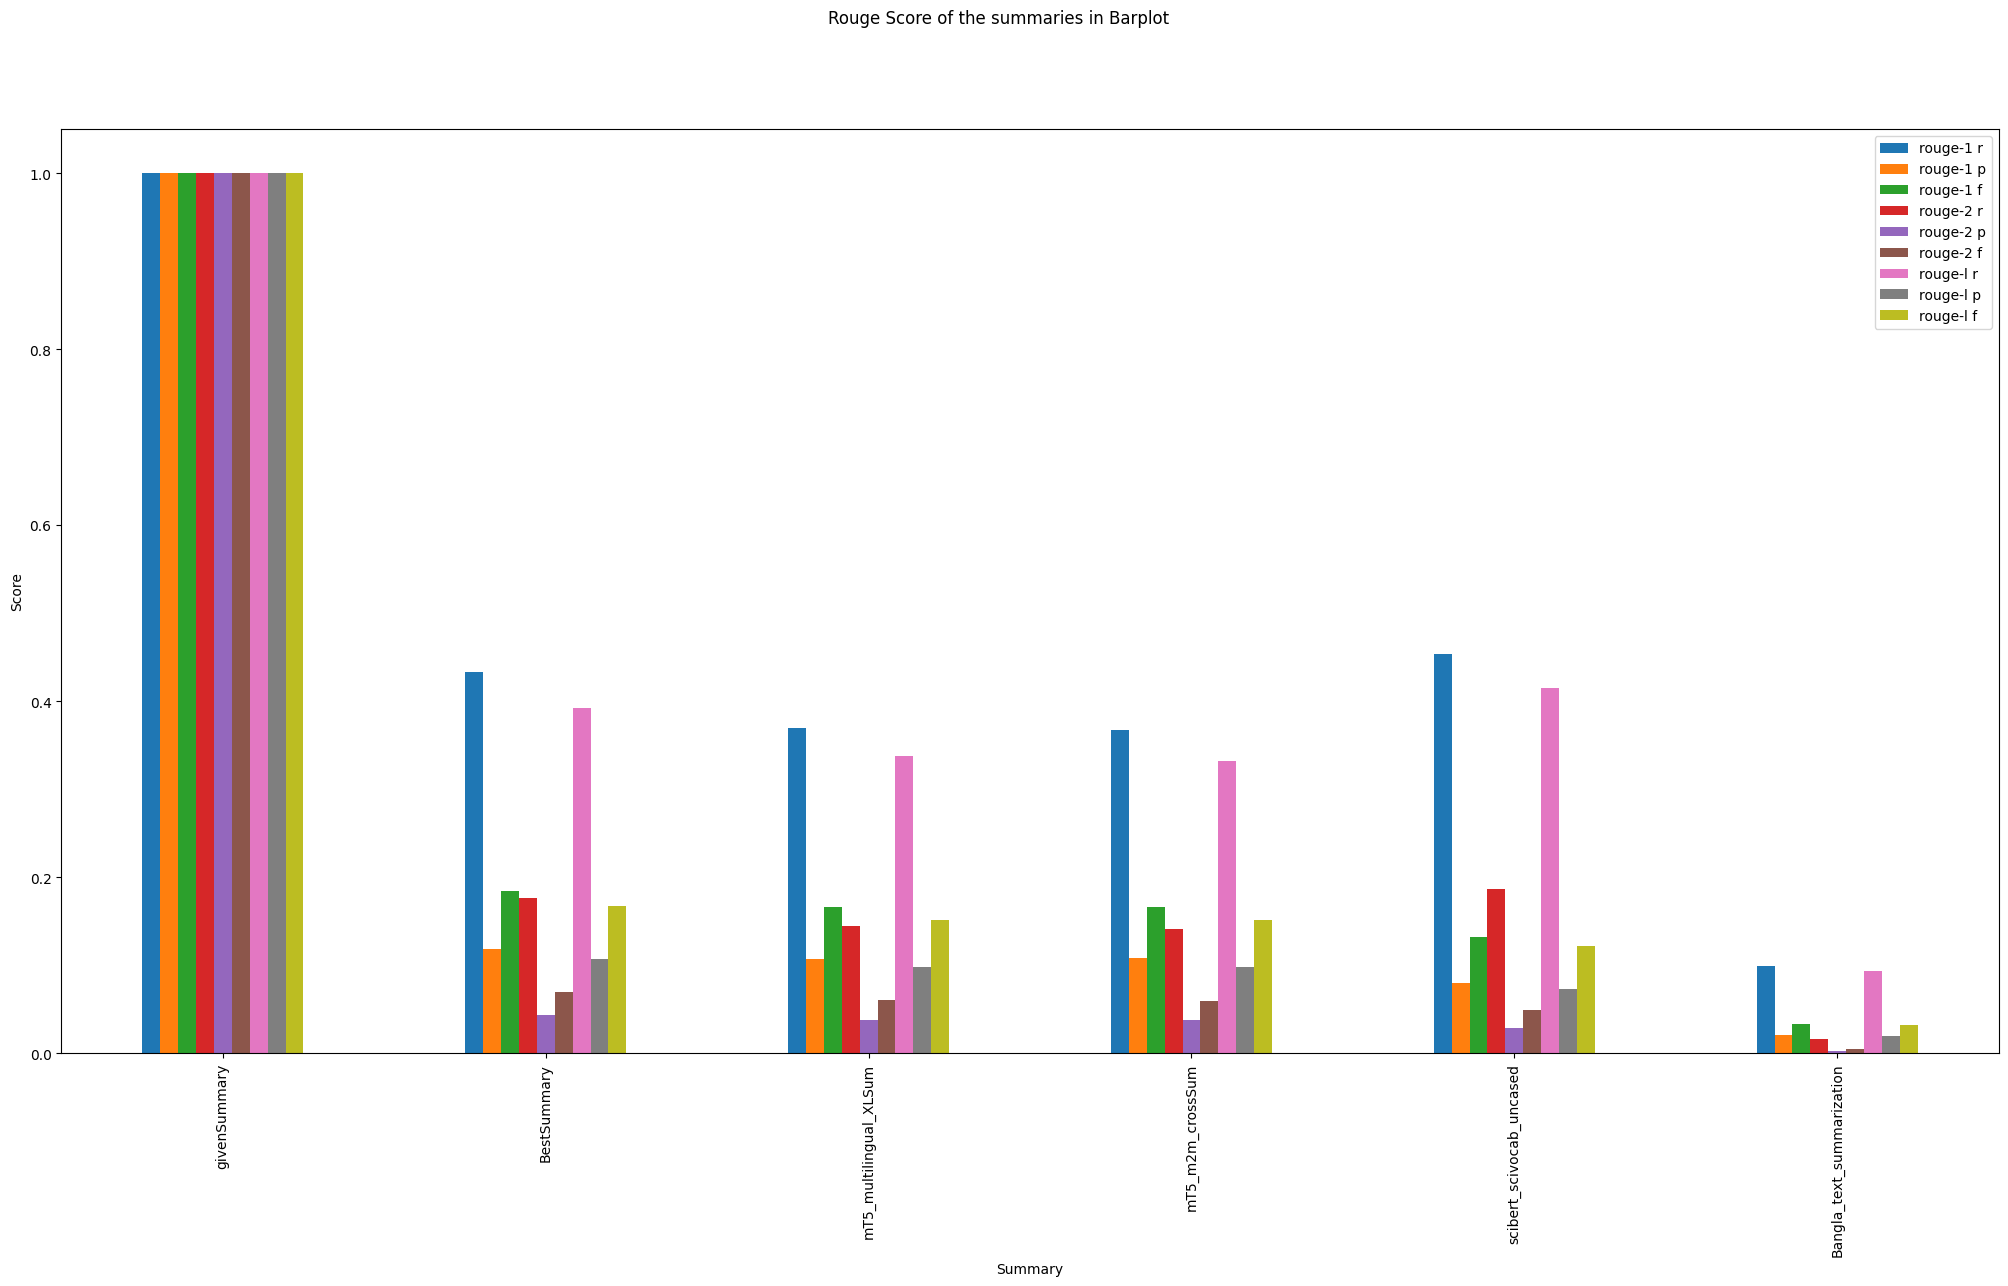

In [26]:
import matplotlib.pyplot as plt

# plotting graph
rougeDf.plot(x="Summary",
               y=['rouge-1 r',
                'rouge-1 p',
                'rouge-1 f',
                'rouge-2 r',
                'rouge-2 p',
                'rouge-2 f',
                'rouge-l r',
                'rouge-l p',
                'rouge-l f'],
               kind="bar", figsize=(25, 12))

plt.suptitle("Rouge Score of the summaries in Barplot\n\n\n\n\n\n")
plt.ylabel("Score")

##### Rouge Comparing with Given Summary Dataset I

In [ ]:
def rougeScoreWithGivenSummary(columnName):
    SummaryEv = finalDF.filter(['givenSummary', columnName], axis=1)
    # return SummaryEv
    urlCSV = '/content/' + columnName + 'CSV.csv'
    SummaryEv.to_csv(urlCSV, index=False)

    with open(urlCSV, 'r') as f:
        dict_reader = DictReader(f)
        SummaryEv_dict = list(dict_reader)

    EvJson = json.dumps(SummaryEv_dict, indent = 4)
    JSON = columnName + 'EvJson.json'
    save_file_at_dir('/content', JSON, EvJson)

    urlJSON = '/content/' + columnName + 'EvJson.json'

    with open(urlJSON) as f:
        SummaryEvData = json.load(f)
    lenS = len(SummaryEvData)
    rscore1r = 0
    rscore1p = 0
    rscore1f = 0
    rscore2r = 0
    rscore2p = 0
    rscore2f = 0
    rscorelr = 0
    rscorelp = 0
    rscorelf = 0
    rouge = Rouge()
    for i in range(lenS):
        score = rouge.get_scores(SummaryEvData[i][columnName], SummaryEvData[i]['givenSummary'])
        rscore1r = rscore1r + score[0]['rouge-1']['r']
        rscore1p = rscore1p + score[0]['rouge-1']['p']
        rscore1f = rscore1f + score[0]['rouge-1']['f']
        rscore2r = rscore2r + score[0]['rouge-2']['r']
        rscore2p = rscore2p + score[0]['rouge-2']['p']
        rscore2f = rscore2f + score[0]['rouge-2']['f']
        rscorelr = rscorelr + score[0]['rouge-l']['r']
        rscorelp = rscorelp + score[0]['rouge-l']['p']
        rscorelf = rscorelf + score[0]['rouge-l']['f']

        # rscore = [[rscore1r/lenS, rscore1p/lenS, rscore1f/lenS],
        #           [rscore2r/lenS, rscore2p/lenS, rscore2f/lenS],
        #           [rscorelr/lenS, rscorelp/lenS, rscorelf/lenS]]

    rscore = {'rouge-1': {'r': rscore1r/lenS,
                        'p': rscore1p/lenS,
                        'f': rscore1f/lenS},
                'rouge-2': {'r': rscore2r/lenS,
                        'p': rscore2p/lenS,
                        'f': rscore2f/lenS},
                'rouge-l': {'r': rscorelr/lenS,
                        'p': rscorelp/lenS,
                        'f': rscorelf/lenS}}
    return rscore

In [ ]:
bsg = rougeScoreWithGivenSummary('BestSummary')
bsg

{'rouge-1': {'r': 0.3128525327465549,
  'p': 0.22249947262910658,
  'f': 0.2485069639452539},
 'rouge-2': {'r': 0.13186963909941574,
  'p': 0.09624546654978744,
  'f': 0.10673689300799105},
 'rouge-l': {'r': 0.2603731567655058,
  'p': 0.1857311903311782,
  'f': 0.20771506914907265}}

In [ ]:
mxg = rougeScoreWithGivenSummary('mT5_multilingual_XLSum')
mxg

{'rouge-1': {'r': 0.287564759327496,
  'p': 0.22651678509425313,
  'f': 0.2454227113791189},
 'rouge-2': {'r': 0.12457369843039469,
  'p': 0.0960402943128843,
  'f': 0.10462677500464472},
 'rouge-l': {'r': 0.2454185699897424,
  'p': 0.19091003417531055,
  'f': 0.20797916308871858}}

In [ ]:
mcg = rougeScoreWithGivenSummary('mT5_m2m_crossSum')
mcg

{'rouge-1': {'r': 0.23457601193686675,
  'p': 0.1869908025730743,
  'f': 0.20143627983831675},
 'rouge-2': {'r': 0.08771204607431907,
  'p': 0.06801591852253562,
  'f': 0.07391844747143643},
 'rouge-l': {'r': 0.1965814050474691,
  'p': 0.15485874784530831,
  'f': 0.16771666515247993}}

In [ ]:
scig = rougeScoreWithGivenSummary('scibert_scivocab_uncased')
scig

{'rouge-1': {'r': 0.27707602328604103,
  'p': 0.07491121735154838,
  'f': 0.11233689862582975},
 'rouge-2': {'r': 0.07154391046050637,
  'p': 0.017825297595239403,
  'f': 0.027072862116853485},
 'rouge-l': {'r': 0.20239842216777168,
  'p': 0.05474144192390803,
  'f': 0.08197041383990689}}

In [ ]:
btsg = rougeScoreWithGivenSummary('Bangla_text_summarization')
btsg

{'rouge-1': {'r': 0.017035330578199285,
  'p': 0.010197499878923192,
  'f': 0.012376467034012852},
 'rouge-2': {'r': 0.0005040024146759152,
  'p': 0.0002670800098852802,
  'f': 0.00034123984411539706},
 'rouge-l': {'r': 0.016160326249158592,
  'p': 0.009644420421394729,
  'f': 0.011715583743129884}}

In [ ]:
def getScore(m, n, x):
    strs = 'rouge-'+str(n)
    return m[strs][x]

In [ ]:
import pandas as pd

data = {'columns':['rouge-1 r', 'rouge-1 p', 'rouge-1 f', 'rouge-2 r', 'rouge-2 p', 'rouge-2 f', 'rouge-l r', 'rouge-l p', 'rouge-l f'],
        'BestSummary':[getScore(bsg, 1, 'r'), getScore(bsg, 1, 'p'), getScore(bsg, 1, 'f'), getScore(bsg, 2, 'r'), getScore(bsg, 2, 'p'), getScore(bsg, 2, 'f'), getScore(bsg, 'l', 'r'), getScore(bsg, 'l', 'p'), getScore(bsg, 'l', 'f')],
        'mT5_multilingual_XLSum':[getScore(mxg, 1, 'r'), getScore(mxg, 1, 'p'), getScore(mxg, 1, 'f'), getScore(mxg, 2, 'r'), getScore(mxg, 2, 'p'), getScore(mxg, 2, 'f'), getScore(mxg, 'l', 'r'), getScore(mxg, 'l', 'p'), getScore(mxg, 'l', 'f')],
        'mT5_m2m_crossSum':[getScore(mcg, 1, 'r'), getScore(mcg, 1, 'p'), getScore(mcg, 1, 'f'), getScore(mcg, 2, 'r'), getScore(mcg, 2, 'p'), getScore(mcg, 2, 'f'), getScore(mcg, 'l', 'r'), getScore(mcg, 'l', 'p'), getScore(mcg, 'l', 'f')],
        'scibert_scivocab_uncased':[getScore(scig, 1, 'r'), getScore(scig, 1, 'p'), getScore(scig, 1, 'f'), getScore(scig, 2, 'r'), getScore(scig, 2, 'p'), getScore(scig, 2, 'f'), getScore(scig, 'l', 'r'), getScore(scig, 'l', 'p'), getScore(scig, 'l', 'f')],
        'Bangla_text_summarization':[getScore(btsg, 1, 'r'), getScore(btsg, 1, 'p'), getScore(btsg, 1, 'f'), getScore(btsg, 2, 'r'), getScore(btsg, 2, 'p'), getScore(btsg, 2, 'f'), getScore(btsg, 'l', 'r'), getScore(btsg, 'l', 'p'), getScore(btsg, 'l', 'f')]}

rougeDf = pd.DataFrame(data)
rougeDf_ = rougeDf
rougeDf = rougeDf.reset_index(drop=True).T
rougeDf = rougeDf.rename(columns=rougeDf.iloc[0]).drop(rougeDf.index[0])
rougeDf.reset_index(inplace=True)
rougeDf = rougeDf.rename(columns = {'index':'Summary'})
rougeDf

,Summary,rouge-1 r,rouge-1 p,rouge-1 f,rouge-2 r,rouge-2 p,rouge-2 f,rouge-l r,rouge-l p,rouge-l f
0,BestSummary,0.312853,0.222499,0.248507,0.13187,0.096245,0.106737,0.260373,0.185731,0.207715
1,mT5_multilingual_XLSum,0.287565,0.226517,0.245423,0.124574,0.09604,0.104627,0.245419,0.19091,0.207979
2,mT5_m2m_crossSum,0.234576,0.186991,0.201436,0.087712,0.068016,0.073918,0.196581,0.154859,0.167717
3,scibert_scivocab_uncased,0.277076,0.074911,0.112337,0.071544,0.017825,0.027073,0.202398,0.054741,0.08197
4,Bangla_text_summarization,0.017035,0.010197,0.012376,0.000504,0.000267,0.000341,0.01616,0.009644,0.011716


Text(0, 0.5, 'Score')

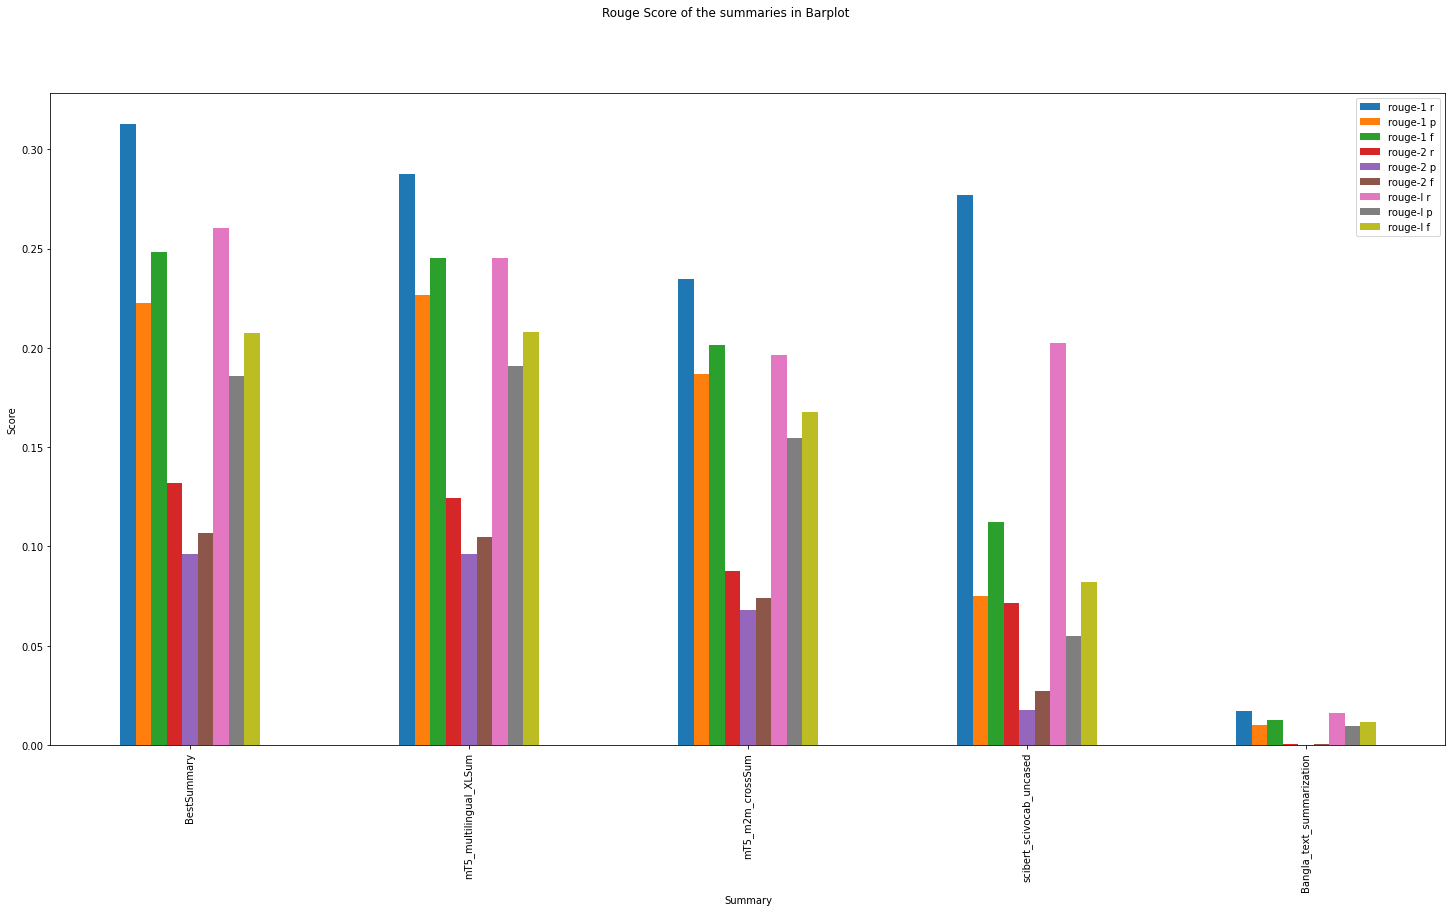

In [ ]:
import matplotlib.pyplot as plt

# plotting graph
rougeDf.plot(x="Summary",
               y=['rouge-1 r',
                'rouge-1 p',
                'rouge-1 f',
                'rouge-2 r',
                'rouge-2 p',
                'rouge-2 f',
                'rouge-l r',
                'rouge-l p',
                'rouge-l f'],
               kind="bar", figsize=(25, 12))

plt.suptitle("Rouge Score of the summaries in Barplot\n\n\n\n\n\n")
plt.ylabel("Score")

### Bleu

#### corpus_bleu: row wise calculation

In [48]:
import os
import json
from csv import DictReader

def save_file_at_dir(dir_path, filename, file_content, mode='w'):
    os.makedirs(dir_path, exist_ok=True)
    with open(os.path.join(dir_path, filename), mode) as f:
        f.write(file_content)

finalDF.to_csv('/content/bleuEvCSV.csv', index=False)

with open("/content/bleuEvCSV.csv", 'r') as f:
    dict_reader = DictReader(f)
    bleu_dict = list(dict_reader)
print(len(bleu_dict))

bleuEvJson = json.dumps(bleu_dict, indent = 4)
save_file_at_dir('/content', 'bleuEvJson.json', bleuEvJson)

with open('/content/bleuEvJson.json') as f:
  bleuData = json.load(f)

8102


In [49]:
finalDF2.to_csv('/content/bleuEvCSV2.csv', index=False)

with open("/content/bleuEvCSV2.csv", 'r') as f:
    dict_reader = DictReader(f)
    bleu_dict = list(dict_reader)
print(len(bleu_dict))

bleuEvJson = json.dumps(bleu_dict, indent = 4)
save_file_at_dir('/content', 'bleuEvJson2.json', bleuEvJson)

with open('/content/bleuEvJson2.json') as f:
  bleuData2 = json.load(f)

4988


In [50]:
import nltk

hypothesis = bleuData[1]['BestSummary'].split()
reference = bleuData[1]['givenSummary'].split()
references = [reference] # list of references for 1 sentence.
list_of_references = [references] # list of references for all sentences in corpus.
list_of_hypotheses = [hypothesis] # list of hypotheses that corresponds to list of references.
nltk.translate.bleu_score.corpus_bleu(list_of_references, list_of_hypotheses, weights=(0.25, 0.25, 0.25, 0.25))

0.4116245235860851

##### Dataset I

In [ ]:
import nltk

def bleuCorpass(columnName):
    ble1score = 0
    ble2score = 0
    ble3score = 0
    ble4score = 0
    for i in range(len(bleuData)):
        hypothesis = bleuData[i][columnName].split()
        reference = bleuData[i]['givenSummary'].split()
        references = [reference]
        list_of_references = [references]
        list_of_hypotheses = [hypothesis]
        ble1score = ble1score + nltk.translate.bleu_score.corpus_bleu(list_of_references, list_of_hypotheses, weights=(1, 0, 0, 0))
        ble2score = ble2score + nltk.translate.bleu_score.corpus_bleu(list_of_references, list_of_hypotheses, weights=(0.5, 0.5, 0, 0))
        ble3score = ble3score + nltk.translate.bleu_score.corpus_bleu(list_of_references, list_of_hypotheses, weights=(0.33, 0.33, 0.33, 0))
        ble4score = ble4score + nltk.translate.bleu_score.corpus_bleu(list_of_references, list_of_hypotheses, weights=(0.25, 0.25, 0.25, 0.25))

    print("Bleu 1: ", ble1score/len(bleuData),'\n')
    print("Bleu 2: ", ble2score/len(bleuData),'\n')
    print("Bleu 3: ", ble3score/len(bleuData),'\n')
    print("Bleu 4: ", ble4score/len(bleuData),'\n')

    return ble1score/len(bleuData), ble2score/len(bleuData), ble3score/len(bleuData), ble4score/len(bleuData)

In [ ]:
print('BestSummary Bleu:', bleuCorpass('BestSummary'))

Bleu 1:  0.2072011897231873 

Bleu 2:  0.1249633793417226 

Bleu 3:  0.07832055735265879 

Bleu 4:  0.04960810715288198 

BestSummary Bleu: (0.2072011897231873, 0.1249633793417226, 0.07832055735265879, 0.04960810715288198)


In [ ]:
print('mT5_multilingual_XLSum Bleu:', bleuCorpass('mT5_multilingual_XLSum'))

Bleu 1:  0.2079067666668448 

Bleu 2:  0.12405887669718738 

Bleu 3:  0.07651821403186336 

Bleu 4:  0.046342228517221265 

mT5_multilingual_XLSum Bleu: (0.2079067666668448, 0.12405887669718738, 0.07651821403186336, 0.046342228517221265)


In [ ]:
print('mT5_m2m_crossSum Bleu:', bleuCorpass('mT5_m2m_crossSum'))

Bleu 1:  0.17061776547131732 

Bleu 2:  0.08978379701091824 

Bleu 3:  0.05025609405136289 

Bleu 4:  0.029064600343398306 

mT5_m2m_crossSum Bleu: (0.17061776547131732, 0.08978379701091824, 0.05025609405136289, 0.029064600343398306)


In [ ]:
print('scibert_scivocab_uncased Bleu:', bleuCorpass('scibert_scivocab_uncased'))

Bleu 1:  0.06753224774853908 

Bleu 2:  0.028199948381990036 

Bleu 3:  0.01255779616910778 

Bleu 4:  0.0064420491453843825 

scibert_scivocab_uncased Bleu: (0.06753224774853908, 0.028199948381990036, 0.01255779616910778, 0.0064420491453843825)


In [ ]:
print('Bangla_text_summarization Bleu:', bleuCorpass('Bangla_text_summarization'))

Bleu 1:  0.009402649209158856 

Bleu 2:  0.0004098776705632275 

Bleu 3:  1.13155882530942e-05 

Bleu 4:  2.9172129182579076e-82 

Bangla_text_summarization Bleu: (0.009402649209158856, 0.0004098776705632275, 1.13155882530942e-05, 2.9172129182579076e-82)


##### Dataset II

In [51]:
import nltk

def bleuCorpass(columnName):
    ble1score = 0
    ble2score = 0
    ble3score = 0
    ble4score = 0
    for i in range(len(bleuData2)):
        hypothesis = bleuData2[i][columnName].split()
        reference = bleuData2[i]['givenSummary'].split()
        references = [reference]
        list_of_references = [references]
        list_of_hypotheses = [hypothesis]
        ble1score = ble1score + nltk.translate.bleu_score.corpus_bleu(list_of_references, list_of_hypotheses, weights=(1, 0, 0, 0))
        ble2score = ble2score + nltk.translate.bleu_score.corpus_bleu(list_of_references, list_of_hypotheses, weights=(0.5, 0.5, 0, 0))
        ble3score = ble3score + nltk.translate.bleu_score.corpus_bleu(list_of_references, list_of_hypotheses, weights=(0.33, 0.33, 0.33, 0))
        ble4score = ble4score + nltk.translate.bleu_score.corpus_bleu(list_of_references, list_of_hypotheses, weights=(0.25, 0.25, 0.25, 0.25))

    print("Bleu 1: ", ble1score/len(bleuData2),'\n')
    print("Bleu 2: ", ble2score/len(bleuData2),'\n')
    print("Bleu 3: ", ble3score/len(bleuData2),'\n')
    print("Bleu 4: ", ble4score/len(bleuData2),'\n')

    return ble1score/len(bleuData2), ble2score/len(bleuData2), ble3score/len(bleuData2), ble4score/len(bleuData2)

In [52]:
print('BestSummary Bleu:', bleuCorpass('BestSummary'))

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

Bleu 1:  0.11599836759192023 

Bleu 2:  0.06142107047875497 

Bleu 3:  0.030052591294437228 

Bleu 4:  0.013096132585451763 

BestSummary Bleu: (0.11599836759192023, 0.06142107047875497, 0.030052591294437228, 0.013096132585451763)


In [53]:
print('mT5_multilingual_XLSum Bleu:', bleuCorpass('mT5_multilingual_XLSum'))

Bleu 1:  0.10648928320364938 

Bleu 2:  0.05348993664821628 

Bleu 3:  0.025320965020699575 

Bleu 4:  0.010857345358434467 

mT5_multilingual_XLSum Bleu: (0.10648928320364938, 0.05348993664821628, 0.025320965020699575, 0.010857345358434467)


In [54]:
print('mT5_m2m_crossSum Bleu:', bleuCorpass('mT5_m2m_crossSum'))

Bleu 1:  0.10751919325459025 

Bleu 2:  0.05348054229360763 

Bleu 3:  0.024818714415685325 

Bleu 4:  0.010246745159521096 

mT5_m2m_crossSum Bleu: (0.10751919325459025, 0.05348054229360763, 0.024818714415685325, 0.010246745159521096)


In [55]:
print('scibert_scivocab_uncased Bleu:', bleuCorpass('scibert_scivocab_uncased'))

Bleu 1:  0.07261220861516882 

Bleu 2:  0.039828085253648234 

Bleu 3:  0.02004732165851196 

Bleu 4:  0.008976753327318574 

scibert_scivocab_uncased Bleu: (0.07261220861516882, 0.039828085253648234, 0.02004732165851196, 0.008976753327318574)


In [56]:
print('Bangla_text_summarization Bleu:', bleuCorpass('Bangla_text_summarization'))

Bleu 1:  0.01793002366730771 

Bleu 2:  0.0038345429360676026 

Bleu 3:  0.0009261355853229585 

Bleu 4:  0.00019657169655747572 

Bangla_text_summarization Bleu: (0.01793002366730771, 0.0038345429360676026, 0.0009261355853229585, 0.00019657169655747572)


## bertscore

#### bertscore Calculation Row Wise

In [57]:
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 16.3 MB/s eta 0:00:00


In [59]:
!pip install bert_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.1 MB/s eta 0:00:00


In [60]:
from evaluate import load
bertscore = load("bertscore")

In [61]:
predictions = ["ভ্লাদিমির পুতিন তাঁর ক্ষমতায় থাকার ২০ বছর পূর্ণ করতে যাচ্ছেন।"]
references = ["রাশিয়ার প্রেসিডেন্ট ভ্লাদিমির পুতিন তাঁর ক্ষমতায় থাকার ২০ বছর পূর্ণ করতে যাচ্ছেন।"]
results = bertscore.compute(predictions=predictions, references=references, lang="bn")
results

{'precision': [0.9533112049102783],
 'recall': [0.8764463067054749],
 'f1': [0.9132643342018127],
 'hashcode': 'bert-base-multilingual-cased_L9_no-idf_version=0.3.12(hug_trans=4.30.2)'}

In [62]:
results['precision'][0]

0.9533112049102783

In [63]:
import sys
print(sys.getrecursionlimit())
sys.setrecursionlimit(8200)
print(sys.getrecursionlimit())

import os
import json
from csv import DictReader

8200
8200


In [64]:
def save_file_at_dir(dir_path, filename, file_content, mode='w'):
    os.makedirs(dir_path, exist_ok=True)
    with open(os.path.join(dir_path, filename), mode) as f:
        f.write(file_content)

##### BERT Comparing with Given Text

In [ ]:
def bertScore(columnName):
    SummaryEv = finalDF.filter(['text', columnName], axis=1)

    lenS = SummaryEv.shape[0]
    bert_precision = 0
    bert_recall = 0
    bert_f1 = 0

    for i in range(lenS):
        results = bertscore.compute(predictions=[SummaryEv[columnName][i]], references=[SummaryEv['text'][i]], lang="bn")

        bert_precision = bert_precision + results['precision'][0]
        bert_recall = bert_recall + results['recall'][0]
        bert_f1 = bert_f1 + results['f1'][0]

    bert_score = {'precision': bert_precision/lenS,
                    'recall': bert_recall/lenS,
                    'f1': bert_f1/lenS}
    return bert_score

In [ ]:
gs = bertScore('givenSummary')
gs

{'precision': 0.7362635335313689,
 'recall': 0.6200163426795908,
 'f1': 0.6728137666738878}

In [ ]:
bs = bertScore('BestSummary')
bs

{'precision': 0.7943252843563953,
 'recall': 0.663861165471031,
 'f1': 0.7225260016977625}

In [ ]:
mx = bertScore('mT5_multilingual_XLSum')
mx

{'precision': 0.7981327591016539,
 'recall': 0.6494891772635688,
 'f1': 0.7159707436250246}

In [ ]:
mc = bertScore('mT5_m2m_crossSum')
mc

{'precision': 0.7870802241647664,
 'recall': 0.6452626567642001,
 'f1': 0.7089076689057102}

In [ ]:
sci = bertScore('scibert_scivocab_uncased')
sci

{'precision': 0.8143223098577378,
 'recall': 0.7502343626603231,
 'f1': 0.7798068429460882}

In [ ]:
bts = bertScore('Bangla_text_summarization')
bts

{'precision': 0.6489181624639478,
 'recall': 0.6035106969126888,
 'f1': 0.6253401173747224}

In [ ]:
bts['precision']

0.6489181624639478

In [ ]:
def getScore(m, x):
    strs = x
    return m[strs]

In [ ]:
import pandas as pd

data = {'columns':['bert_precision', 'bert_recall', 'bert_f1'],
        'givenSummary':[getScore(gs, 'precision'), getScore(gs, 'recall'), getScore(gs, 'f1')],
        'BestSummary':[getScore(bs, 'precision'), getScore(bs, 'recall'), getScore(bs, 'f1')],
        'mT5_multilingual_XLSum':[getScore(mx, 'precision'), getScore(mx, 'recall'), getScore(mx, 'f1')],
        'mT5_m2m_crossSum':[getScore(mc, 'precision'), getScore(mc, 'recall'), getScore(mc, 'f1')],
        'scibert_scivocab_uncased':[getScore(sci, 'precision'), getScore(sci, 'recall'), getScore(sci, 'f1')],
        'Bangla_text_summarization':[getScore(bts, 'precision'), getScore(bts, 'recall'), getScore(bts, 'f1')]}

bertScoreDf = pd.DataFrame(data)
bertScoreDf_ = bertScoreDf
bertScoreDf = bertScoreDf.reset_index(drop=True).T
bertScoreDf = bertScoreDf.rename(columns=bertScoreDf.iloc[0]).drop(bertScoreDf.index[0])
bertScoreDf.reset_index(inplace=True)
bertScoreDf = bertScoreDf.rename(columns = {'index':'Summary'})
bertScoreDf

,Summary,bert_precision,bert_recall,bert_f1
0,givenSummary,0.736264,0.620016,0.672814
1,BestSummary,0.794325,0.663861,0.722526
2,mT5_multilingual_XLSum,0.798133,0.649489,0.715971
3,mT5_m2m_crossSum,0.78708,0.645263,0.708908
4,scibert_scivocab_uncased,0.814322,0.750234,0.779807
5,Bangla_text_summarization,0.648918,0.603511,0.62534


Text(0, 0.5, 'Score')

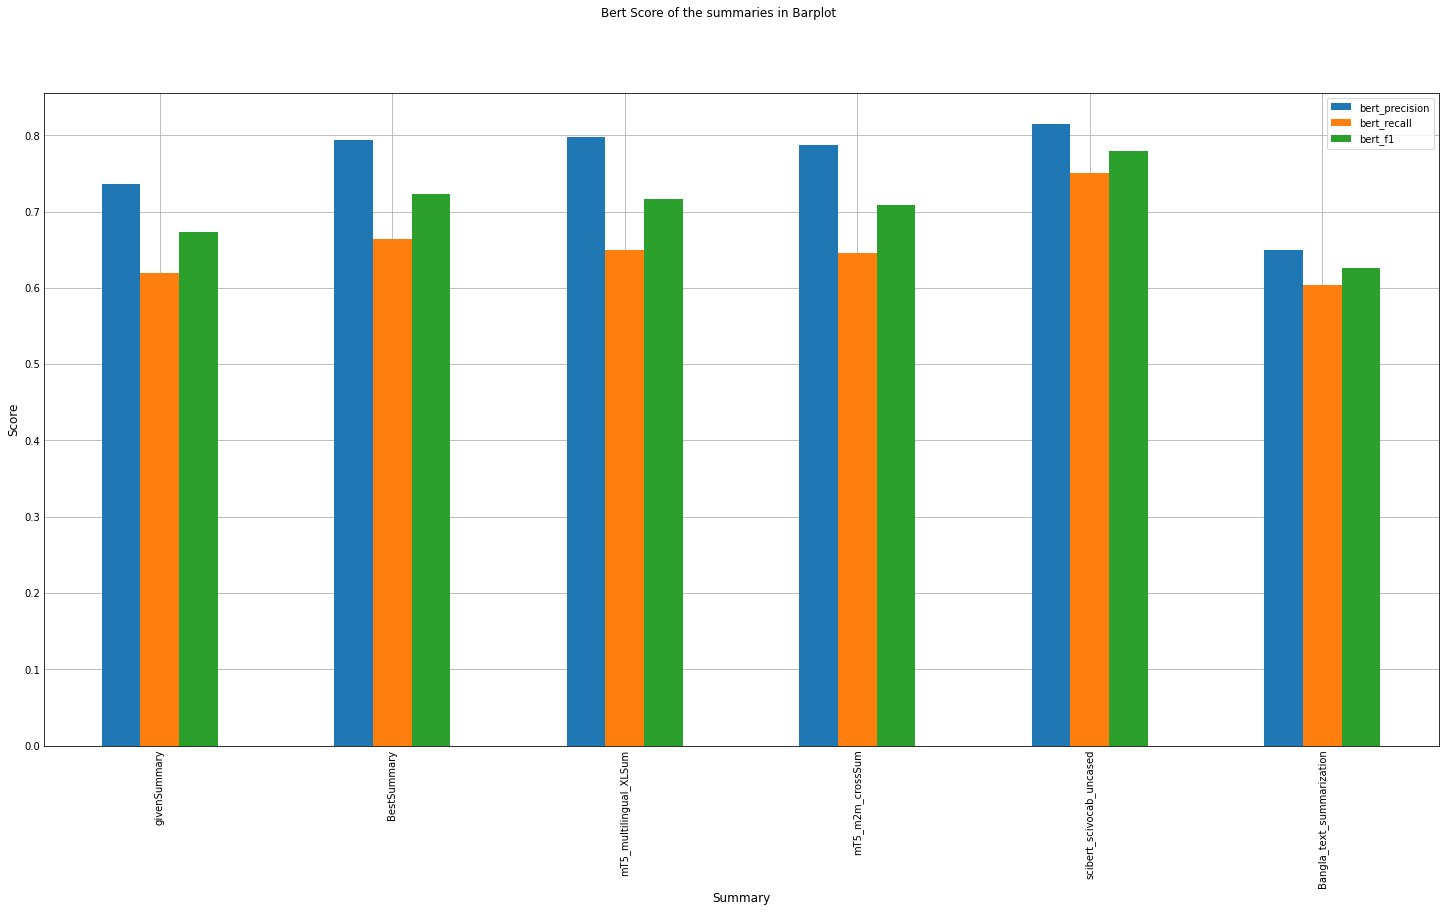

In [ ]:
import matplotlib.pyplot as plt

# plotting graph
bertScoreDf.plot(x="Summary",
               y=['bert_precision',
                'bert_recall',
                'bert_f1'],
               kind="bar", figsize=(25, 12))

plt.suptitle("Bert Score of the summaries in Barplot\n\n\n\n\n\n")
plt.ylabel("Score")

##### BERT Comparing with Given Text Dataset II

In [65]:
def bertScore(columnName):
    SummaryEv = finalDF2.filter(['text', columnName], axis=1)

    lenS = SummaryEv.shape[0]
    bert_precision = 0
    bert_recall = 0
    bert_f1 = 0

    for i in range(lenS):
        results = bertscore.compute(predictions=[SummaryEv[columnName][i]], references=[SummaryEv['text'][i]], lang="bn")

        bert_precision = bert_precision + results['precision'][0]
        bert_recall = bert_recall + results['recall'][0]
        bert_f1 = bert_f1 + results['f1'][0]

    bert_score = {'precision': bert_precision/lenS,
                    'recall': bert_recall/lenS,
                    'f1': bert_f1/lenS}
    return bert_score

In [ ]:
gs = bertScore('givenSummary')
gs

In [ ]:
bs = bertScore('BestSummary')
bs

In [ ]:
mx = bertScore('mT5_multilingual_XLSum')
mx

In [ ]:
mc = bertScore('mT5_m2m_crossSum')
mc

In [ ]:
sci = bertScore('scibert_scivocab_uncased')
sci

In [ ]:
bts = bertScore('Bangla_text_summarization')
bts

In [ ]:
bts['precision']

In [ ]:
def getScore(m, x):
    strs = x
    return m[strs]

In [ ]:
import pandas as pd

data = {'columns':['bert_precision', 'bert_recall', 'bert_f1'],
        'givenSummary':[getScore(gs, 'precision'), getScore(gs, 'recall'), getScore(gs, 'f1')],
        'BestSummary':[getScore(bs, 'precision'), getScore(bs, 'recall'), getScore(bs, 'f1')],
        'mT5_multilingual_XLSum':[getScore(mx, 'precision'), getScore(mx, 'recall'), getScore(mx, 'f1')],
        'mT5_m2m_crossSum':[getScore(mc, 'precision'), getScore(mc, 'recall'), getScore(mc, 'f1')],
        'scibert_scivocab_uncased':[getScore(sci, 'precision'), getScore(sci, 'recall'), getScore(sci, 'f1')],
        'Bangla_text_summarization':[getScore(bts, 'precision'), getScore(bts, 'recall'), getScore(bts, 'f1')]}

bertScoreDf = pd.DataFrame(data)
bertScoreDf_ = bertScoreDf
bertScoreDf = bertScoreDf.reset_index(drop=True).T
bertScoreDf = bertScoreDf.rename(columns=bertScoreDf.iloc[0]).drop(bertScoreDf.index[0])
bertScoreDf.reset_index(inplace=True)
bertScoreDf = bertScoreDf.rename(columns = {'index':'Summary'})
bertScoreDf

In [ ]:
import matplotlib.pyplot as plt

# plotting graph
bertScoreDf.plot(x="Summary",
               y=['bert_precision',
                'bert_recall',
                'bert_f1'],
               kind="bar", figsize=(25, 12))

plt.suptitle("Bert Score of the summaries in Barplot\n\n\n\n\n\n")
plt.ylabel("Score")

##### BERT Comparing with Given Summary

In [ ]:
def bertScore(columnName):
    SummaryEv = finalDF.filter(['givenSummary', columnName], axis=1)

    lenS = SummaryEv.shape[0]
    bert_precision = 0
    bert_recall = 0
    bert_f1 = 0

    for i in range(lenS):
        results = bertscore.compute(predictions=[SummaryEv[columnName][i]], references=[SummaryEv['givenSummary'][i]], lang="bn")

        bert_precision = bert_precision + results['precision'][0]
        bert_recall = bert_recall + results['recall'][0]
        bert_f1 = bert_f1 + results['f1'][0]

    bert_score = {'precision': bert_precision/lenS,
                    'recall': bert_recall/lenS,
                    'f1': bert_f1/lenS}
    return bert_score

In [ ]:
bs = bertScore('BestSummary')
bs

{'precision': 0.7339922946136812,
 'recall': 0.7657511411802588,
 'f1': 0.7488766785125266}

In [ ]:
mx = bertScore('mT5_multilingual_XLSum')
mx

{'precision': 0.7392360686417186,
 'recall': 0.7612992188748652,
 'f1': 0.7495491358637074}

In [ ]:
mc = bertScore('mT5_m2m_crossSum')
mc

{'precision': 0.7274497912286741,
 'recall': 0.7437931542645498,
 'f1': 0.7350525484353458}

In [ ]:
sci = bertScore('scibert_scivocab_uncased')
sci

{'precision': 0.6419531604267291,
 'recall': 0.7228173400201612,
 'f1': 0.6794799904092333}

In [ ]:
bts = bertScore('Bangla_text_summarization')
bts

{'precision': 0.6040710917308695,
 'recall': 0.63557943333905,
 'f1': 0.6192731427663758}

In [ ]:
def getScore(m, x):
    strs = x
    return m[strs]

In [ ]:
import pandas as pd

data = {'columns':['bert_precision', 'bert_recall', 'bert_f1'],
        'BestSummary':[getScore(bs, 'precision'), getScore(bs, 'recall'), getScore(bs, 'f1')],
        'mT5_multilingual_XLSum':[getScore(mx, 'precision'), getScore(mx, 'recall'), getScore(mx, 'f1')],
        'mT5_m2m_crossSum':[getScore(mc, 'precision'), getScore(mc, 'recall'), getScore(mc, 'f1')],
        'scibert_scivocab_uncased':[getScore(sci, 'precision'), getScore(sci, 'recall'), getScore(sci, 'f1')],
        'Bangla_text_summarization':[getScore(bts, 'precision'), getScore(bts, 'recall'), getScore(bts, 'f1')]}

bertScoreDf = pd.DataFrame(data)
bertScoreDf_ = bertScoreDf
bertScoreDf = bertScoreDf.reset_index(drop=True).T
bertScoreDf = bertScoreDf.rename(columns=bertScoreDf.iloc[0]).drop(bertScoreDf.index[0])
bertScoreDf.reset_index(inplace=True)
bertScoreDf = bertScoreDf.rename(columns = {'index':'Summary'})
bertScoreDf

,Summary,bert_precision,bert_recall,bert_f1
0,BestSummary,0.733992,0.765751,0.748877
1,mT5_multilingual_XLSum,0.739236,0.761299,0.749549
2,mT5_m2m_crossSum,0.72745,0.743793,0.735053
3,scibert_scivocab_uncased,0.641953,0.722817,0.67948
4,Bangla_text_summarization,0.604071,0.635579,0.619273


Text(0, 0.5, 'Score')

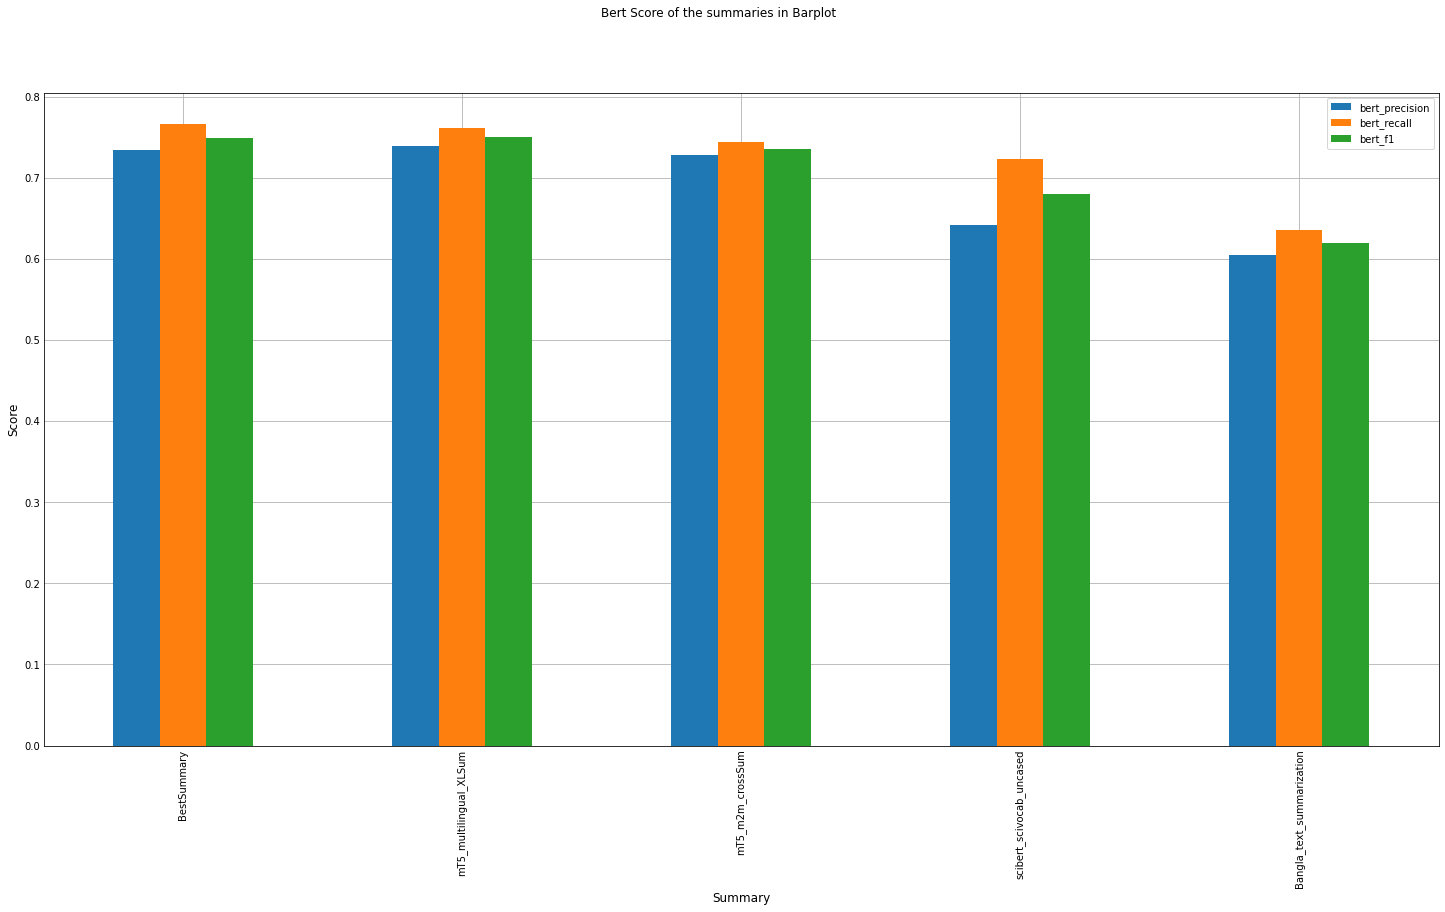

In [ ]:
import matplotlib.pyplot as plt

# plotting graph
bertScoreDf.plot(x="Summary",
               y=['bert_precision',
                'bert_recall',
                'bert_f1'],
               kind="bar", figsize=(25, 12))

plt.suptitle("Bert Score of the summaries in Barplot\n\n\n\n\n\n")
plt.ylabel("Score")

##### BERT Comparing with Given Summary Dataset II

In [ ]:
def bertScore(columnName):
    SummaryEv = finalDF2.filter(['givenSummary', columnName], axis=1)

    lenS = SummaryEv.shape[0]
    bert_precision = 0
    bert_recall = 0
    bert_f1 = 0

    for i in range(lenS):
        results = bertscore.compute(predictions=[SummaryEv[columnName][i]], references=[SummaryEv['givenSummary'][i]], lang="bn")

        bert_precision = bert_precision + results['precision'][0]
        bert_recall = bert_recall + results['recall'][0]
        bert_f1 = bert_f1 + results['f1'][0]

    bert_score = {'precision': bert_precision/lenS,
                    'recall': bert_recall/lenS,
                    'f1': bert_f1/lenS}
    return bert_score

In [ ]:
bs = bertScore('BestSummary')
bs

In [ ]:
mx = bertScore('mT5_multilingual_XLSum')
mx

In [ ]:
mc = bertScore('mT5_m2m_crossSum')
mc

In [ ]:
sci = bertScore('scibert_scivocab_uncased')
sci

In [ ]:
bts = bertScore('Bangla_text_summarization')
bts

In [ ]:
def getScore(m, x):
    strs = x
    return m[strs]

In [ ]:
import pandas as pd

data = {'columns':['bert_precision', 'bert_recall', 'bert_f1'],
        'BestSummary':[getScore(bs, 'precision'), getScore(bs, 'recall'), getScore(bs, 'f1')],
        'mT5_multilingual_XLSum':[getScore(mx, 'precision'), getScore(mx, 'recall'), getScore(mx, 'f1')],
        'mT5_m2m_crossSum':[getScore(mc, 'precision'), getScore(mc, 'recall'), getScore(mc, 'f1')],
        'scibert_scivocab_uncased':[getScore(sci, 'precision'), getScore(sci, 'recall'), getScore(sci, 'f1')],
        'Bangla_text_summarization':[getScore(bts, 'precision'), getScore(bts, 'recall'), getScore(bts, 'f1')]}

bertScoreDf = pd.DataFrame(data)
bertScoreDf_ = bertScoreDf
bertScoreDf = bertScoreDf.reset_index(drop=True).T
bertScoreDf = bertScoreDf.rename(columns=bertScoreDf.iloc[0]).drop(bertScoreDf.index[0])
bertScoreDf.reset_index(inplace=True)
bertScoreDf = bertScoreDf.rename(columns = {'index':'Summary'})
bertScoreDf

In [ ]:
import matplotlib.pyplot as plt

# plotting graph
bertScoreDf.plot(x="Summary",
               y=['bert_precision',
                'bert_recall',
                'bert_f1'],
               kind="bar", figsize=(25, 12))

plt.suptitle("Bert Score of the summaries in Barplot\n\n\n\n\n\n")
plt.ylabel("Score")

## Three Scores

#### MeteorScore

In [27]:
from collections import Counter

class MeteorScore:
    def __init__(self, alpha=0.5, beta=0.5, gamma=0.5):
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma

    def preprocess_sentence(self, sentence):
        words = sentence.split()
        return words

    def ngram_count(self, sentence, n):
        words = self.preprocess_sentence(sentence)
        ngrams = [tuple(words[i:i+n]) for i in range(len(words)-n+1)]
        return Counter(ngrams)

    def compute_precision(self, hypothesis, reference, n):
        hyp_counts = self.ngram_count(hypothesis, n)
        ref_counts = self.ngram_count(reference, n)
        overlap = sum((hyp_counts & ref_counts).values())
        precision = overlap / sum(hyp_counts.values()) if sum(hyp_counts.values()) > 0 else 0
        return precision

    def compute_recall(self, hypothesis, reference, n):
        hyp_counts = self.ngram_count(hypothesis, n)
        ref_counts = self.ngram_count(reference, n)
        overlap = sum((hyp_counts & ref_counts).values())
        recall = overlap / sum(ref_counts.values()) if sum(ref_counts.values()) > 0 else 0
        return recall

    def meteor_score(self, hypothesis, reference):
        precision = self.alpha * self.compute_precision(hypothesis, reference, 1) + (1-self.alpha) * self.compute_precision(hypothesis, reference, 2)
        recall = self.beta * self.compute_recall(hypothesis, reference, 1) + (1-self.beta) * self.compute_recall(hypothesis, reference, 2)
        fmean = (1-self.gamma) * precision + self.gamma * recall if (precision != 0 and recall != 0) else 0
        return fmean

### jiwer

In [28]:
!pip install jiwer
import jiwer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 23.8 MB/s eta 0:00:00


#### wilWerMeteor Comparing with Given Text

In [ ]:
meteor = MeteorScore(alpha=0.5, beta=0.5, gamma=0.5)

def wilWerMeteorScore(columnName):
    SummaryEv = finalDF.filter(['text', columnName], axis=1)

    lenS = SummaryEv.shape[0]
    wer_score = 0
    meteor_score = 0
    wil_score = 0

    for i in range(lenS):
        wer_result = jiwer.wer(SummaryEv['text'][i], SummaryEv[columnName][i])
        meteor_result = meteor.meteor_score(SummaryEv[columnName][i], SummaryEv['text'][i])
        wil_result = jiwer.wil(SummaryEv['text'][i], SummaryEv[columnName][i])

        wer_score = wer_score + wer_result
        meteor_score = meteor_score + meteor_result
        wil_score = wil_score + wil_result

    wilWerMeteor_score = {'METEOR': meteor_score/lenS,
                    'WER': wer_score/lenS,
                    'WIL': wil_score/lenS}

    return wilWerMeteor_score
    # return spice_score/lenS

In [ ]:
gs = wilWerMeteorScore('givenSummary')
gs

{'METEOR': 0.19550542274831012,
 'WER': 0.982496056880675,
 'WIL': 0.9927589426315556}

In [ ]:
bs = wilWerMeteorScore('BestSummary')
bs

{'METEOR': 0.3469283321911064,
 'WER': 0.9469807245946897,
 'WIL': 0.9583518346111152}

In [ ]:
mx = wilWerMeteorScore('mT5_multilingual_XLSum')
mx

{'METEOR': 0.3196007040595473,
 'WER': 0.9696993932723706,
 'WIL': 0.9827520409356477}

In [ ]:
mc = wilWerMeteorScore('mT5_m2m_crossSum')
mc

{'METEOR': 0.29565803468637064,
 'WER': 0.9719706468499425,
 'WIL': 0.9849010049580549}

In [ ]:
sci = wilWerMeteorScore('scibert_scivocab_uncased')
sci

{'METEOR': 0.578906225724212,
 'WER': 0.8124326641731866,
 'WIL': 0.8135979986556472}

In [ ]:
bts = wilWerMeteorScore('Bangla_text_summarization')
bts

{'METEOR': 0.024636148121141094,
 'WER': 0.9958052396441807,
 'WIL': 0.9996059475560369}

In [ ]:
def getScore(m, x):
    strs = x
    return m[strs]

In [ ]:
import pandas as pd

data = {'columns':['WIL', 'METEOR', 'WER'],
        'givenSummary':[getScore(gs, 'WIL'), getScore(gs, 'METEOR'), getScore(gs, 'WER')],
        'BestSummary':[getScore(bs, 'WIL'), getScore(bs, 'METEOR'), getScore(bs, 'WER')],
        'mT5_multilingual_XLSum':[getScore(mx, 'WIL'), getScore(mx, 'METEOR'), getScore(mx, 'WER')],
        'mT5_m2m_crossSum':[getScore(mc, 'WIL'), getScore(mc, 'METEOR'), getScore(mc, 'WER')],
        'scibert_scivocab_uncased':[getScore(sci, 'WIL'), getScore(sci, 'METEOR'), getScore(sci, 'WER')],
        'Bangla_text_summarization':[getScore(bts, 'WIL'), getScore(bts, 'METEOR'), getScore(bts, 'WER')]}

threeScoreDf = pd.DataFrame(data)
threeScoreDf_ = threeScoreDf
threeScoreDf = threeScoreDf.reset_index(drop=True).T
threeScoreDf = threeScoreDf.rename(columns=threeScoreDf.iloc[0]).drop(threeScoreDf.index[0])
threeScoreDf.reset_index(inplace=True)
threeScoreDf = threeScoreDf.rename(columns = {'index':'Summary'})
threeScoreDf

,Summary,WIL,METEOR,WER
0,givenSummary,0.992759,0.195505,0.982496
1,BestSummary,0.958352,0.346928,0.946981
2,mT5_multilingual_XLSum,0.982752,0.319601,0.969699
3,mT5_m2m_crossSum,0.984901,0.295658,0.971971
4,scibert_scivocab_uncased,0.813598,0.578906,0.812433
5,Bangla_text_summarization,0.999606,0.024636,0.995805


Text(0, 0.5, 'Score')

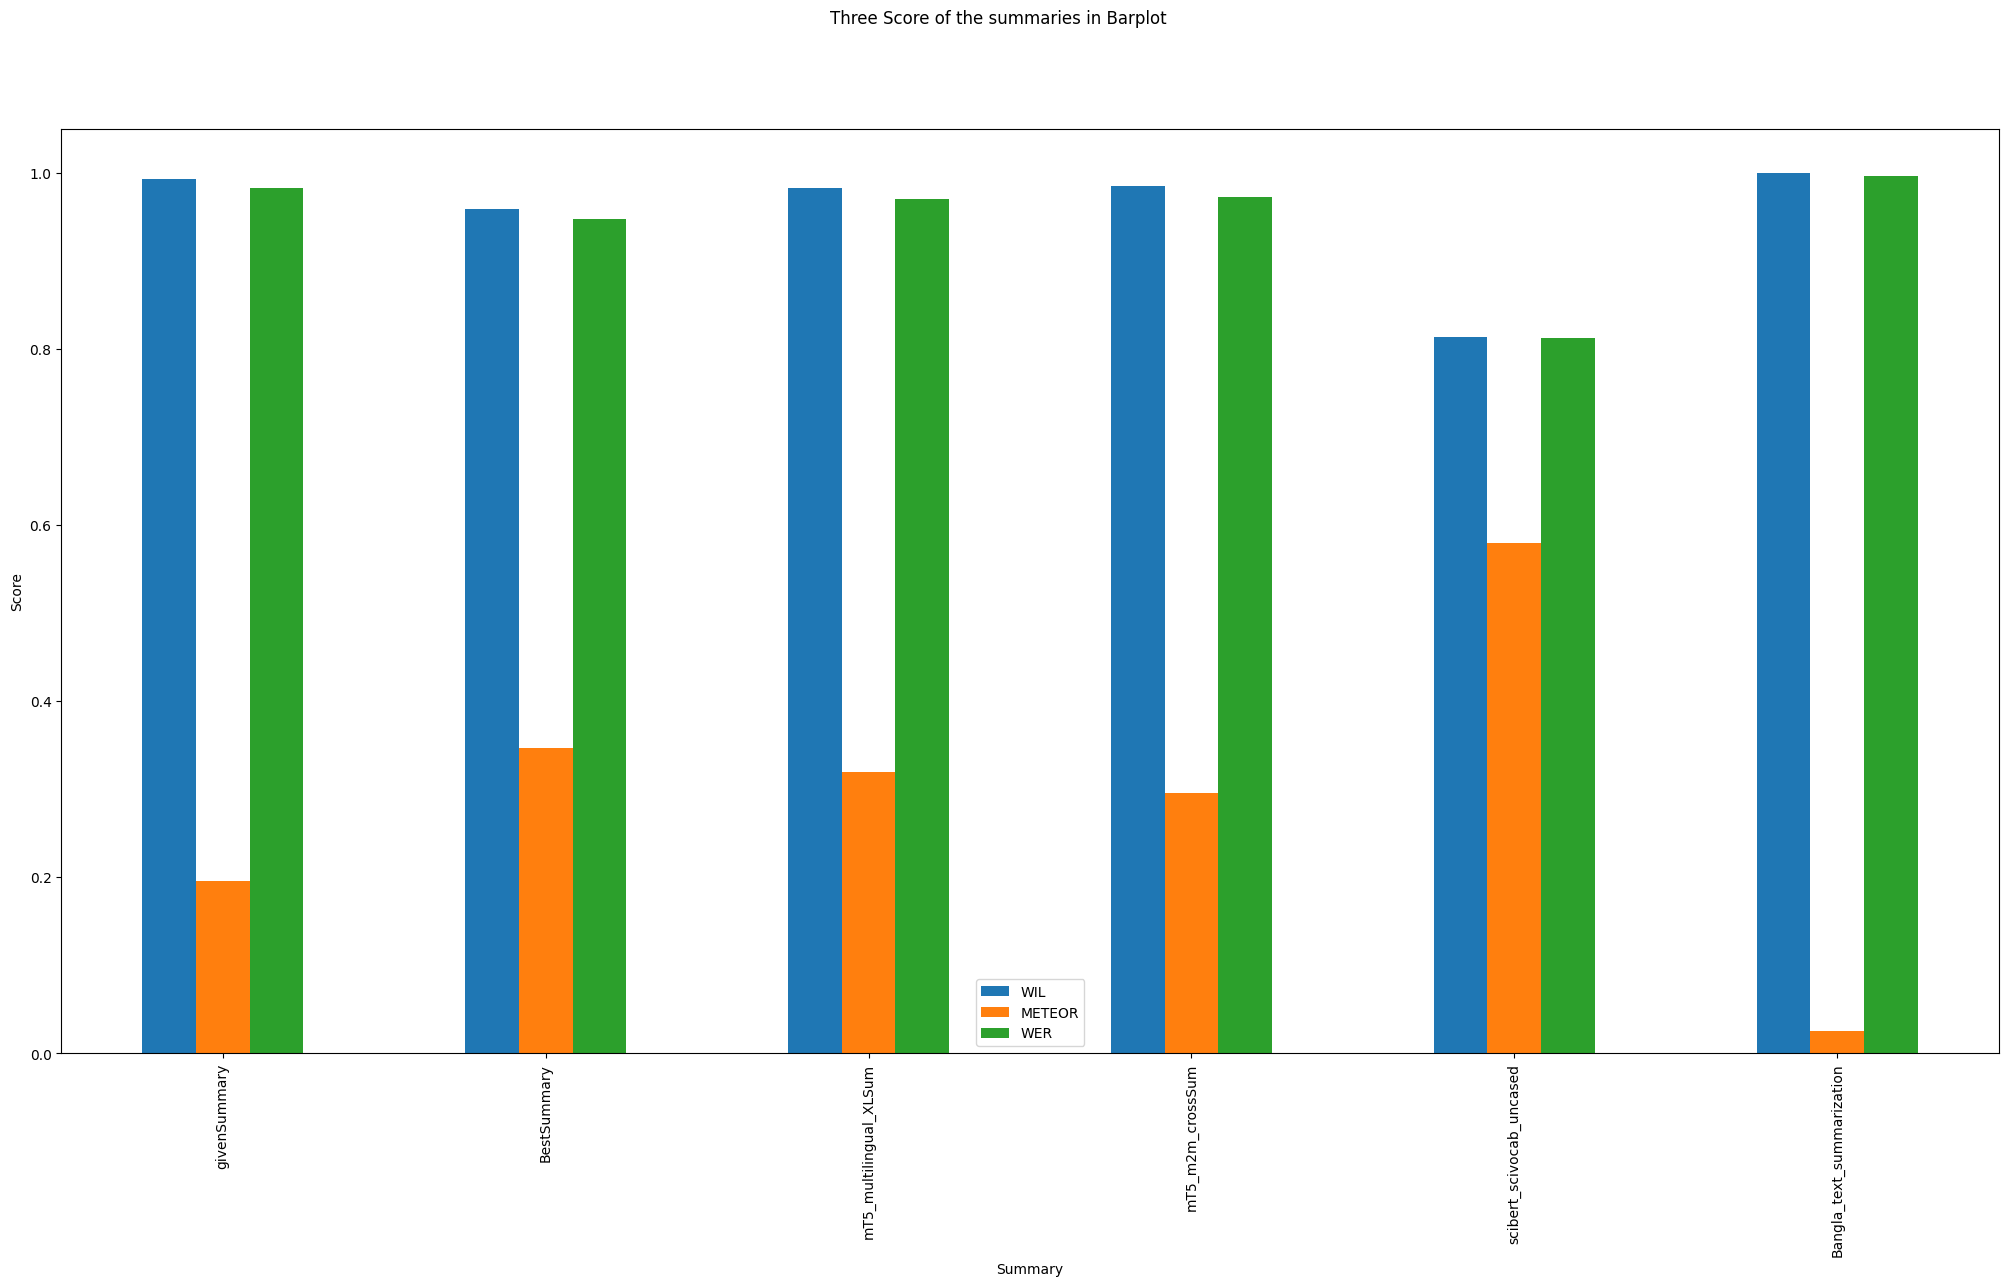

In [ ]:
import matplotlib.pyplot as plt

# plotting graph
threeScoreDf.plot(x="Summary",
               y=['WIL', 'METEOR', 'WER'],
               kind="bar", figsize=(25, 12))

plt.suptitle("Three Score of the summaries in Barplot\n\n\n\n\n\n")
plt.ylabel("Score")

#### wilWerMeteor Comparing with Given Text Dataset II

In [38]:
meteor = MeteorScore(alpha=0.5, beta=0.5, gamma=0.5)

def wilWerMeteorScore(columnName):
    SummaryEv = finalDF2.filter(['text', columnName], axis=1)

    lenS = SummaryEv.shape[0]
    wer_score = 0
    meteor_score = 0
    wil_score = 0

    for i in range(lenS):
        wer_result = jiwer.wer(SummaryEv['text'][i], SummaryEv[columnName][i])
        meteor_result = meteor.meteor_score(SummaryEv[columnName][i], SummaryEv['text'][i])
        wil_result = jiwer.wil(SummaryEv['text'][i], SummaryEv[columnName][i])

        wer_score = wer_score + wer_result
        meteor_score = meteor_score + meteor_result
        wil_score = wil_score + wil_result

    wilWerMeteor_score = {'METEOR': meteor_score/lenS,
                    'WER': wer_score/lenS,
                    'WIL': wil_score/lenS}

    return wilWerMeteor_score
    # return spice_score/lenS

In [39]:
gs = wilWerMeteorScore('givenSummary')
gs

{'METEOR': 0.27803803485716283,
 'WER': 0.9754128785177173,
 'WIL': 0.9822329353309625}

In [40]:
bs = wilWerMeteorScore('BestSummary')
bs

{'METEOR': 0.36087555833414053,
 'WER': 0.901497190515997,
 'WIL': 0.9254502045726201}

In [41]:
mx = wilWerMeteorScore('mT5_multilingual_XLSum')
mx

{'METEOR': 0.3323836852139316,
 'WER': 0.9278564925715936,
 'WIL': 0.9504914066436816}

In [42]:
mc = wilWerMeteorScore('mT5_m2m_crossSum')
mc

{'METEOR': 0.326079333294802,
 'WER': 0.9307227571867803,
 'WIL': 0.9544542745375211}

In [43]:
sci = wilWerMeteorScore('scibert_scivocab_uncased')
sci

{'METEOR': 0.48930256345325185,
 'WER': 0.7950660066418229,
 'WIL': 0.8220367374527348}

In [44]:
bts = wilWerMeteorScore('Bangla_text_summarization')
bts

{'METEOR': 0.03242690257906231,
 'WER': 0.9890360779589568,
 'WIL': 0.9986840816464203}

In [45]:
def getScore(m, x):
    strs = x
    return m[strs]

In [46]:
import pandas as pd

data = {'columns':['WIL', 'METEOR', 'WER'],
        'givenSummary':[getScore(gs, 'WIL'), getScore(gs, 'METEOR'), getScore(gs, 'WER')],
        'BestSummary':[getScore(bs, 'WIL'), getScore(bs, 'METEOR'), getScore(bs, 'WER')],
        'mT5_multilingual_XLSum':[getScore(mx, 'WIL'), getScore(mx, 'METEOR'), getScore(mx, 'WER')],
        'mT5_m2m_crossSum':[getScore(mc, 'WIL'), getScore(mc, 'METEOR'), getScore(mc, 'WER')],
        'scibert_scivocab_uncased':[getScore(sci, 'WIL'), getScore(sci, 'METEOR'), getScore(sci, 'WER')],
        'Bangla_text_summarization':[getScore(bts, 'WIL'), getScore(bts, 'METEOR'), getScore(bts, 'WER')]}

threeScoreDf = pd.DataFrame(data)
threeScoreDf_ = threeScoreDf
threeScoreDf = threeScoreDf.reset_index(drop=True).T
threeScoreDf = threeScoreDf.rename(columns=threeScoreDf.iloc[0]).drop(threeScoreDf.index[0])
threeScoreDf.reset_index(inplace=True)
threeScoreDf = threeScoreDf.rename(columns = {'index':'Summary'})
threeScoreDf

,Summary,WIL,METEOR,WER
0,givenSummary,0.982233,0.278038,0.975413
1,BestSummary,0.92545,0.360876,0.901497
2,mT5_multilingual_XLSum,0.950491,0.332384,0.927856
3,mT5_m2m_crossSum,0.954454,0.326079,0.930723
4,scibert_scivocab_uncased,0.822037,0.489303,0.795066
5,Bangla_text_summarization,0.998684,0.032427,0.989036


Text(0, 0.5, 'Score')

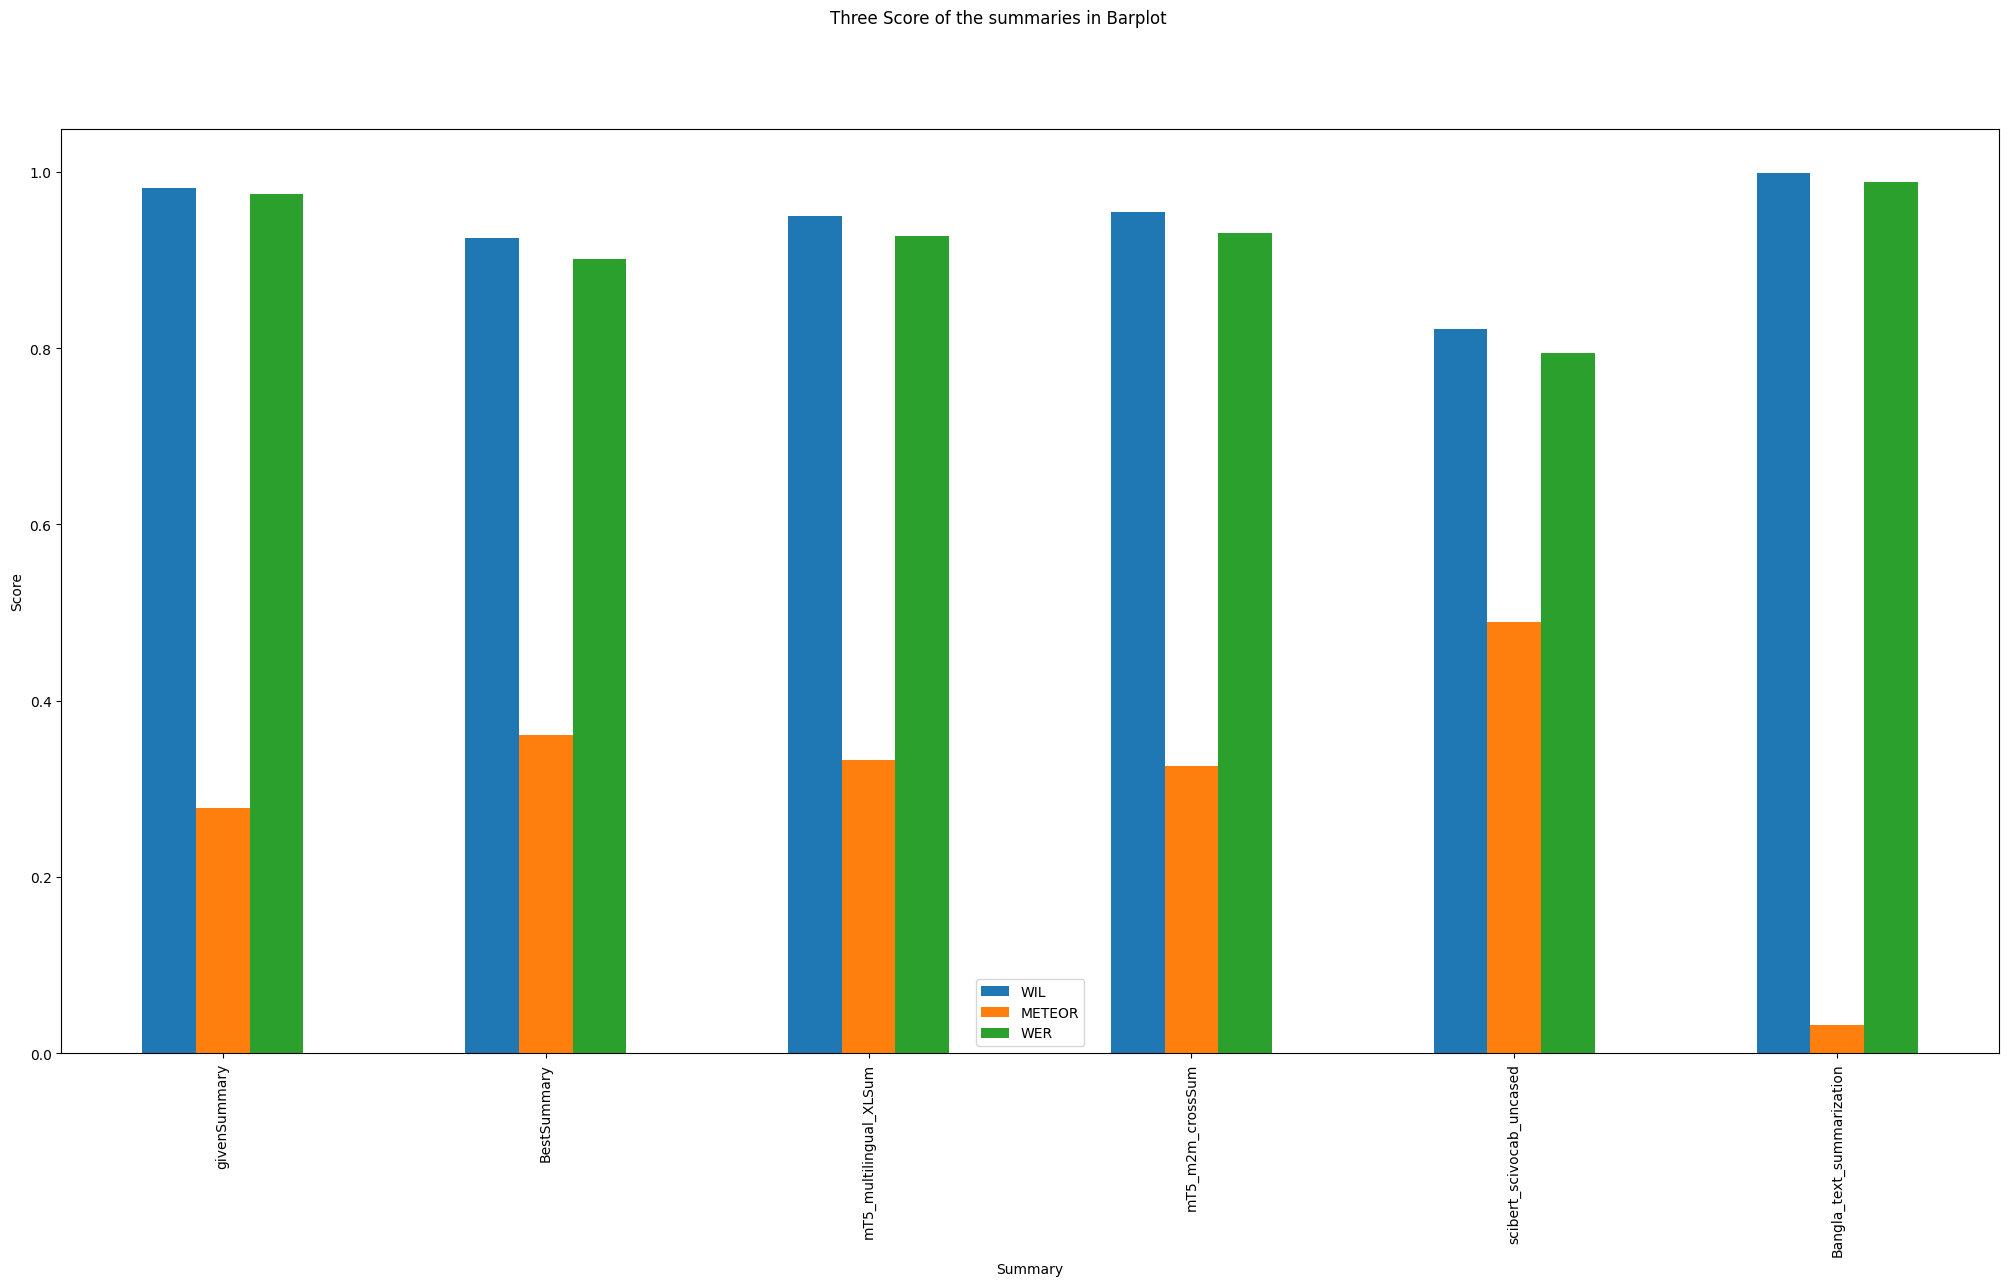

In [47]:
import matplotlib.pyplot as plt

# plotting graph
threeScoreDf.plot(x="Summary",
               y=['WIL', 'METEOR', 'WER'],
               kind="bar", figsize=(25, 12))

plt.suptitle("Three Score of the summaries in Barplot\n\n\n\n\n\n")
plt.ylabel("Score")

#### wilWerMeteor Comparing with Given Summary

In [ ]:
meteor = MeteorScore(alpha=0.5, beta=0.5, gamma=0.5)

def wilWerMeteorScore(columnName):
    SummaryEv = finalDF.filter(['givenSummary', columnName], axis=1)

    lenS = SummaryEv.shape[0]
    wer_score = 0
    meteor_score = 0
    wil_score = 0

    for i in range(lenS):
        wer_result = jiwer.wer(SummaryEv['givenSummary'][i], SummaryEv[columnName][i])
        meteor_result = meteor.meteor_score(SummaryEv[columnName][i], SummaryEv['givenSummary'][i])
        wil_result = jiwer.wil(SummaryEv['givenSummary'][i], SummaryEv[columnName][i])

        wer_score = wer_score + wer_result
        meteor_score = meteor_score + meteor_result
        wil_score = wil_score + wil_result

    wilWerMeteor_score = {'METEOR': meteor_score/lenS,
                    'WER': wer_score/lenS,
                    'WIL': wil_score/lenS}

    return wilWerMeteor_score
    # return spice_score/lenS

In [ ]:
bs = wilWerMeteorScore('BestSummary')
bs

{'METEOR': 0.1890327502801996,
 'WER': 1.736189212798372,
 'WIL': 0.9510634198454103}

In [ ]:
mx = wilWerMeteorScore('mT5_multilingual_XLSum')
mx

{'METEOR': 0.1819200220398466,
 'WER': 1.2571487646750221,
 'WIL': 0.955314751908462}

In [ ]:
mc = wilWerMeteorScore('mT5_m2m_crossSum')
mc

{'METEOR': 0.14289479769877236,
 'WER': 1.2828062884171088,
 'WIL': 0.970279137138471}

In [ ]:
sci = wilWerMeteorScore('scibert_scivocab_uncased')
sci

{'METEOR': 0.10834127721257635,
 'WER': 5.173476591222463,
 'WIL': 0.9903313038301899}

In [ ]:
bts = wilWerMeteorScore('Bangla_text_summarization')
bts

{'METEOR': 0.006765494804034188,
 'WER': 1.9540425725608415,
 'WIL': 0.9997754518579295}

In [ ]:
def getScore(m, x):
    strs = x
    return m[strs]

In [ ]:
import pandas as pd

data = {'columns':['WIL', 'METEOR', 'WER'],
        'BestSummary':[getScore(bs, 'WIL'), getScore(bs, 'METEOR'), getScore(bs, 'WER')],
        'mT5_multilingual_XLSum':[getScore(mx, 'WIL'), getScore(mx, 'METEOR'), getScore(mx, 'WER')],
        'mT5_m2m_crossSum':[getScore(mc, 'WIL'), getScore(mc, 'METEOR'), getScore(mc, 'WER')],
        'scibert_scivocab_uncased':[getScore(sci, 'WIL'), getScore(sci, 'METEOR'), getScore(sci, 'WER')],
        'Bangla_text_summarization':[getScore(bts, 'WIL'), getScore(bts, 'METEOR'), getScore(bts, 'WER')]}

threeScoreDf = pd.DataFrame(data)
threeScoreDf_ = threeScoreDf
threeScoreDf = threeScoreDf.reset_index(drop=True).T
threeScoreDf = threeScoreDf.rename(columns=threeScoreDf.iloc[0]).drop(threeScoreDf.index[0])
threeScoreDf.reset_index(inplace=True)
threeScoreDf = threeScoreDf.rename(columns = {'index':'Summary'})
threeScoreDf

,Summary,WIL,METEOR,WER
0,BestSummary,0.951063,0.189033,1.736189
1,mT5_multilingual_XLSum,0.955315,0.18192,1.257149
2,mT5_m2m_crossSum,0.970279,0.142895,1.282806
3,scibert_scivocab_uncased,0.990331,0.108341,5.173477
4,Bangla_text_summarization,0.999775,0.006765,1.954043


Text(0, 0.5, 'Score')

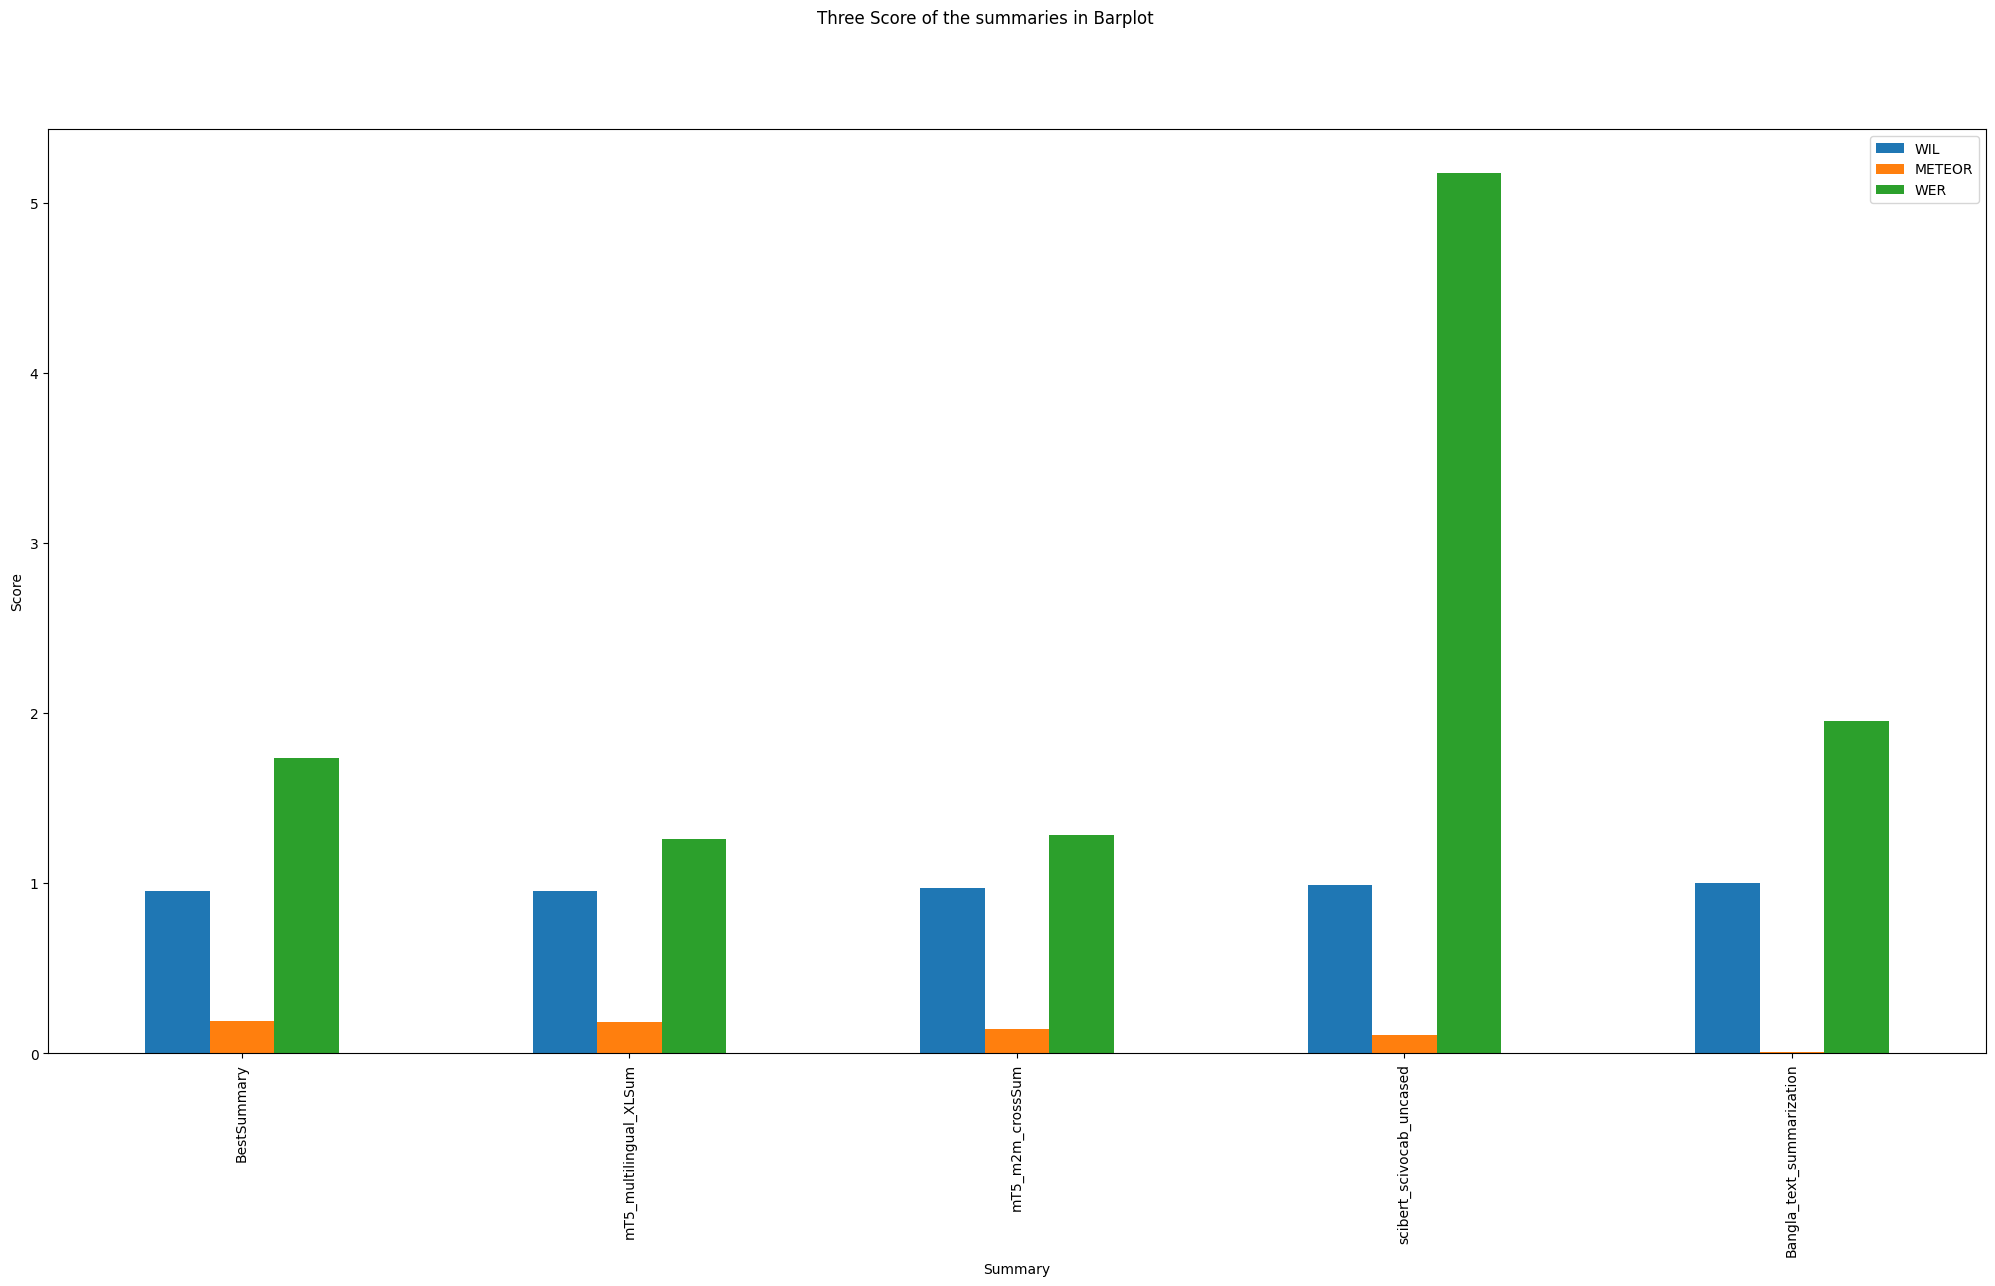

In [ ]:
import matplotlib.pyplot as plt

# plotting graph
threeScoreDf.plot(x="Summary",
               y=['WIL', 'METEOR', 'WER'],
               kind="bar", figsize=(25, 12))

plt.suptitle("Three Score of the summaries in Barplot\n\n\n\n\n\n")
plt.ylabel("Score")

#### wilWerMeteor Comparing with Given Summary Dataset II

In [29]:
meteor = MeteorScore(alpha=0.5, beta=0.5, gamma=0.5)

def wilWerMeteorScore(columnName):
    SummaryEv = finalDF2.filter(['givenSummary', columnName], axis=1)

    lenS = SummaryEv.shape[0]
    wer_score = 0
    meteor_score = 0
    wil_score = 0

    for i in range(lenS):
        wer_result = jiwer.wer(SummaryEv['givenSummary'][i], SummaryEv[columnName][i])
        meteor_result = meteor.meteor_score(SummaryEv[columnName][i], SummaryEv['givenSummary'][i])
        wil_result = jiwer.wil(SummaryEv['givenSummary'][i], SummaryEv[columnName][i])

        wer_score = wer_score + wer_result
        meteor_score = meteor_score + meteor_result
        wil_score = wil_score + wil_result

    wilWerMeteor_score = {'METEOR': meteor_score/lenS,
                    'WER': wer_score/lenS,
                    'WIL': wil_score/lenS}

    return wilWerMeteor_score

In [30]:
bs = wilWerMeteorScore('BestSummary')
bs

{'METEOR': 0.1918176265097392,
 'WER': 4.027306002090917,
 'WIL': 0.9452240269811664}

In [31]:
mx = wilWerMeteorScore('mT5_multilingual_XLSum')
mx

{'METEOR': 0.16411418926532143,
 'WER': 3.195035312342285,
 'WIL': 0.952194889657823}

In [32]:
mc = wilWerMeteorScore('mT5_m2m_crossSum')
mc

{'METEOR': 0.16304342408799613,
 'WER': 3.1392475447273096,
 'WIL': 0.9536280680519884}

In [33]:
sci = wilWerMeteorScore('scibert_scivocab_uncased')
sci

{'METEOR': 0.18516975257169566,
 'WER': 7.823954938490722,
 'WIL': 0.9629925360778967}

In [34]:
bts = wilWerMeteorScore('Bangla_text_summarization')
bts

{'METEOR': 0.033457857555010594,
 'WER': 5.256959000233301,
 'WIL': 0.9960887788995362}

In [35]:
def getScore(m, x):
    strs = x
    return m[strs]

In [36]:
import pandas as pd

data = {'columns':['WIL', 'METEOR', 'WER'],
        'BestSummary':[getScore(bs, 'WIL'), getScore(bs, 'METEOR'), getScore(bs, 'WER')],
        'mT5_multilingual_XLSum':[getScore(mx, 'WIL'), getScore(mx, 'METEOR'), getScore(mx, 'WER')],
        'mT5_m2m_crossSum':[getScore(mc, 'WIL'), getScore(mc, 'METEOR'), getScore(mc, 'WER')],
        'scibert_scivocab_uncased':[getScore(sci, 'WIL'), getScore(sci, 'METEOR'), getScore(sci, 'WER')],
        'Bangla_text_summarization':[getScore(bts, 'WIL'), getScore(bts, 'METEOR'), getScore(bts, 'WER')]}

threeScoreDf = pd.DataFrame(data)
threeScoreDf_ = threeScoreDf
threeScoreDf = threeScoreDf.reset_index(drop=True).T
threeScoreDf = threeScoreDf.rename(columns=threeScoreDf.iloc[0]).drop(threeScoreDf.index[0])
threeScoreDf.reset_index(inplace=True)
threeScoreDf = threeScoreDf.rename(columns = {'index':'Summary'})
threeScoreDf

,Summary,WIL,METEOR,WER
0,BestSummary,0.945224,0.191818,4.027306
1,mT5_multilingual_XLSum,0.952195,0.164114,3.195035
2,mT5_m2m_crossSum,0.953628,0.163043,3.139248
3,scibert_scivocab_uncased,0.962993,0.18517,7.823955
4,Bangla_text_summarization,0.996089,0.033458,5.256959


Text(0, 0.5, 'Score')

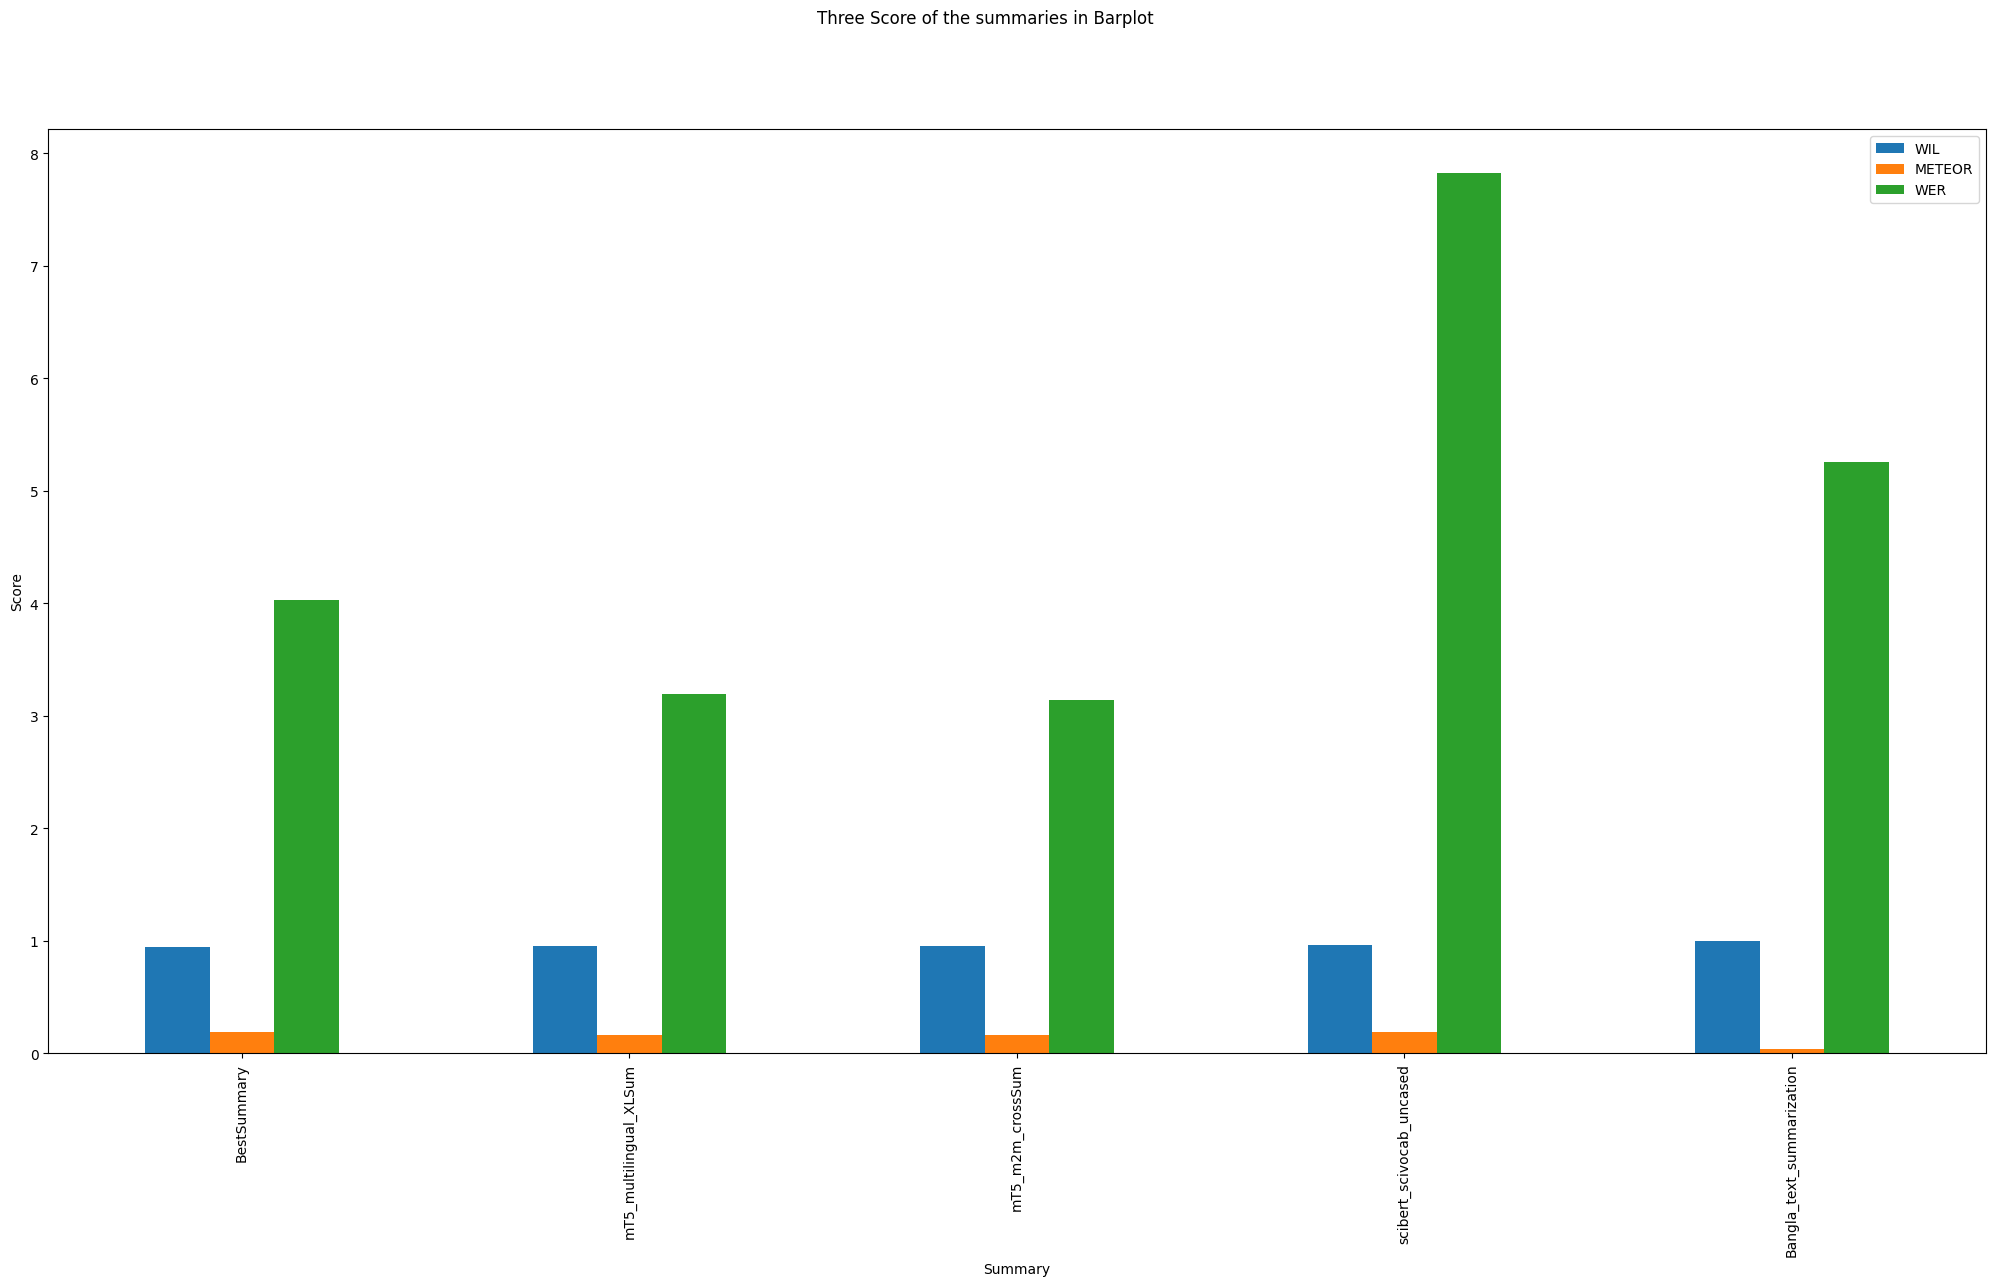

In [37]:
import matplotlib.pyplot as plt

# plotting graph
threeScoreDf.plot(x="Summary",
               y=['WIL', 'METEOR', 'WER'],
               kind="bar", figsize=(25, 12))

plt.suptitle("Three Score of the summaries in Barplot\n\n\n\n\n\n")
plt.ylabel("Score")